In [3]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from sklearn.model_selection import train_test_split
import sklearn.utils
import tensorflow as tf
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt

# Работа с датасетом

In [5]:
# Пути
excel_path = "C:/Users/user/Desktop/Tensor-FLow Project/Filik.xlsx"
image_src_dir = "C:/Users/user/Desktop/Tensor-FLow Project/images"  # папка где все .png
target_base_dir = "C:/Users/user/Desktop/Tensor-FLow Project/images_by_class"  # новая структура

# Чтение Excel
df = pd.read_excel(excel_path)
df.columns = ['filename', 'label_str', 'partition']

# Копирование по папкам
for _, row in df.iterrows():
    label = row['label_str']   # HP или SSA
    part = row['partition']    # train или test
    fname = row['filename']
    
    src_path = os.path.join(image_src_dir, fname)
    dst_dir = os.path.join(target_base_dir, part, label)
    dst_path = os.path.join(dst_dir, fname)

    os.makedirs(dst_dir, exist_ok=True)
    
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"⚠️ Файл не найден: {src_path}")

In [6]:
# Путь к папке test
test_dir = "C:/Users/user/Desktop/Tensor-FLow Project/images_by_class/test"

data = []
for label in ['HP', 'SSA']:
    class_dir = os.path.join(test_dir, label)
    for fname in os.listdir(class_dir):
        data.append({
            'filename': os.path.join(class_dir, fname),
            'class': label
        })

df_test = pd.DataFrame(data)

# Разделить вручную на validation и final test (например, 20% валидация)
df_val, df_final_test = train_test_split(
    df_test, test_size=0.2, stratify=df_test['class'], random_state=42
)

In [8]:
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1
)

In [9]:
train_gen = datagen.flow_from_directory(
    "C:/Users/user/Desktop/Tensor-FLow Project/images_by_class/train",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=16,
    shuffle=True
)

Found 1815 images belonging to 2 classes.


In [10]:
val_gen = datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=16,
    shuffle=False
)

test_gen = datagen.flow_from_dataframe(
    df_final_test,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    class_mode='binary',
    batch_size=16,
    shuffle=False
)

Found 650 validated image filenames belonging to 2 classes.
Found 163 validated image filenames belonging to 2 classes.


# БАЗА CNN

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers

In [34]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.2),

    layers.Dense(1, activation='sigmoid')  # Выход
])

In [36]:
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
    return loss


optimizer = optimizers.Adam(learning_rate=1e-4)

# Компиляция
model.compile(optimizer=optimizer,
              loss=focal_loss(gamma=1.5, alpha=0.75),
              metrics=[
        'accuracy',
        metrics.AUC(name='auc'),
        metrics.Recall(name='tpr'),     # TPR = Recall
        metrics.FalsePositives(name='fp'),
        metrics.TruePositives(name='tp'),
    ]
)

In [54]:
# early_stop = EarlyStopping(
#     monitor='val_loss',        # Можно также 'val_accuracy'
#     patience=3,                # Сколько эпох ждать без заметного улучшения
#     min_delta=0.01,           # Минимальное улучшение между эпохами
#     restore_best_weights=True,
#     verbose=1
# )

checkpoint = ModelCheckpoint(
    'best_model.keras',        # <-- новое расширение .keras
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


# Обучение модели с колбэками
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[checkpoint]
)

Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.7497 - auc: 0.8532 - fp: 173.5351 - loss: 0.0701 - tp: 185.1754 - tpr: 0.7788
Epoch 1: val_loss improved from inf to 0.07940, saving model to best_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 84s 737ms/step - accuracy: 0.7497 - auc: 0.8531 - fp: 175.0000 - loss: 0.0701 - tp: 186.8000 - tpr: 0.7788 - val_accuracy: 0.6908 - val_auc: 0.8208 - val_fp: 161.0000 - val_loss: 0.0794 - val_tp: 196.0000 - val_tpr: 0.8305
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - accuracy: 0.7867 - auc: 0.8789 - fp: 156.1754 - loss: 0.0622 - tp: 205.1754 - tpr: 0.8307
Epoch 2: val_loss did not improve from 0.07940
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 705ms/step - accuracy: 0.7866 - auc: 0.8788 - fp: 157.5565 - loss: 0.0622 - tp: 206.7652 - tpr: 0.8306 - val_accuracy: 0.3662 - val_auc: 0.7609 - val_fp: 412.0000 - val_loss: 0.4146 - val_tp: 236.0000 - val_tpr: 1.0000
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.7589 - a

In [20]:
from tensorflow.keras.models import load_model
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
    return loss

OURCNNmodel = load_model('best_model.keras', custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.75)})

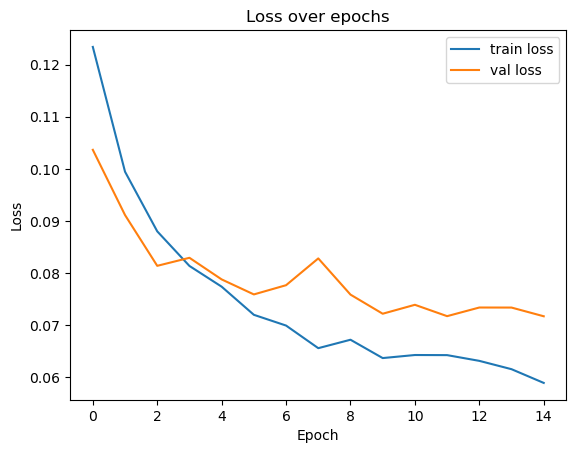

In [88]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/loss_plot.png', dpi=300)
plt.show()

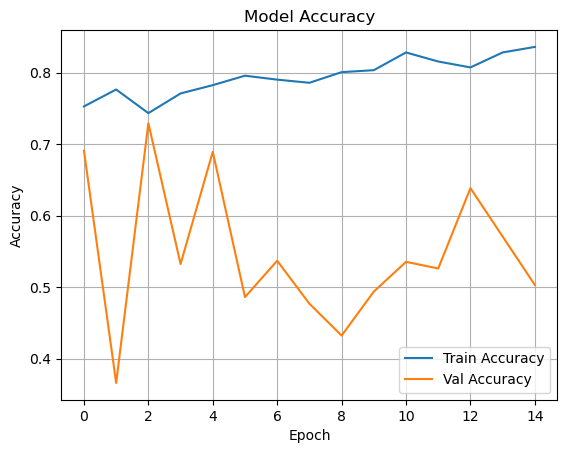

In [75]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Accuracy_plot.png', dpi=300)
plt.show()

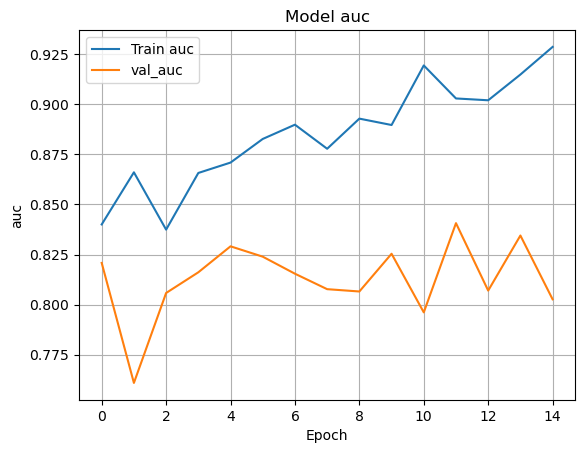

In [81]:
plt.plot(history.history['auc'], label='Train auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/AUC_plot.png', dpi=300)
plt.show()

In [83]:
# Предсказания на тесте
pred_raw = OURCNNmodel.predict(test_gen)

# Получаем бинарные метки (0 или 1), без вероятностей
pred_classes = (pred_raw > 0.5).astype("int").flatten()

# Получаем настоящие метки
true_labels = test_gen.classes

# Выводим первые 10:
for i in range(10):
    print(f"Image {i+1}: predicted = {pred_classes[i]}, true = {true_labels[i]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 273ms/step
Image 1: predicted = 0, true = 0
Image 2: predicted = 1, true = 0
Image 3: predicted = 0, true = 1
Image 4: predicted = 1, true = 0
Image 5: predicted = 1, true = 0
Image 6: predicted = 1, true = 1
Image 7: predicted = 0, true = 0
Image 8: predicted = 1, true = 0
Image 9: predicted = 1, true = 1
Image 10: predicted = 0, true = 0


In [85]:
# Получаем вероятности (от 0 до 1)
pred_probs = OURCNNmodel.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(10)

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step


Filename True Predicted
0  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
2  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
8  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA

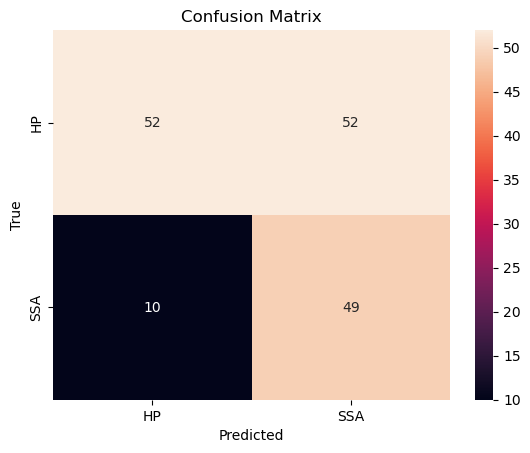

              precision    recall  f1-score   support

          HP       0.84      0.50      0.63       104
         SSA       0.49      0.83      0.61        59

    accuracy                           0.62       163
   macro avg       0.66      0.67      0.62       163
weighted avg       0.71      0.62      0.62       163



In [87]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Confusion_matrix__plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

# RandomSearch for CNN

In [8]:
!pip install keras-tuner


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from keras_tuner import RandomSearch
import keras_tuner as kt

def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
    return loss


def build_model(hp):
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),
        
        layers.Conv2D(hp.Int('conv1_filters', 32, 128, step=32), (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.1)),
    
        layers.Conv2D(hp.Int('conv2_filters', 64, 256, step=64), (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.1)),

        layers.Conv2D(hp.Int('conv3_filters', 128, 512, step=128), (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D(),
        layers.Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.1)),
    
        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', 128, 512, step=64)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Dropout(hp.Float('dropout4', 0.2, 0.5, step=0.1)),
    
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=hp.Choice('lr', [1e-5])),
        loss=focal_loss(gamma=hp.Choice('gamma', [1.5, 2.0]), alpha=hp.Choice('alpha', [0.5, 0.75])),
        metrics=[
            'accuracy',
            metrics.AUC(name='auc'),
            metrics.Recall(name='tpr'),
            metrics.FalsePositives(name='fp'),
            metrics.TruePositives(name='tp'),
        ]
    )
    return model

tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=8,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='base_model_randomsearch'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    min_delta=0.01,
    restore_best_weights=True,
    verbose=1
)

tuner.search(train_gen, validation_data=val_gen, epochs=15, callbacks=[early_stop])

Trial 8 Complete [00h 10m 40s]
val_auc: 0.7017727494239807

Best val_auc So Far: 0.8275096416473389
Total elapsed time: 10h 58m 29s


In [15]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
print(best_hp.values)

Best hyperparameters:
{'conv1_filters': 128, 'dropout1': 0.2, 'conv2_filters': 64, 'dropout2': 0.4, 'dense_units': 448, 'dropout4': 0.30000000000000004, 'lr': 0.0001, 'gamma': 1.5, 'alpha': 0.5, 'conv3_filters': 512, 'dropout3': 0.30000000000000004}


C:\Users\user\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [34]:
import pandas as pd

# Получаем все испытания
trials = tuner.oracle.trials.values()

# Собираем гиперпараметры и метрики
trial_data = []

for trial in trials:
    data = trial.hyperparameters.values.copy()  # Гиперпараметры
    data['trial_id'] = trial.trial_id

    # Извлекаем метрики
    for metric_name, metric_history in trial.metrics.metrics.items():
        # Получаем список всех наблюдений метрики
        observations = metric_history.get_history()
        if observations:
            # Извлекаем последнее значение метрики
            last_value = observations[-1].value
            data[metric_name] = last_value
        else:
            data[metric_name] = None  # Если метрика отсутствует

    trial_data.append(data)

# Преобразуем в DataFrame
df_trials = pd.DataFrame(trial_data)

# Сохраняем в CSV
df_trials.to_excel('C:/Users/user/Downloads/cnn_randomsearch_results1.xlsx', index=False)

# Просмотр первых строк
df_trials.head(8)

conv1_filters  dropout1  conv2_filters  dropout2  dense_units  dropout4  \
0             32       0.2             64       0.4          256       0.4   
1            128       0.4            192       0.3          512       0.2   
2             32       0.4             64       0.2          128       0.3   
3             64       0.4            192       0.4          256       0.4   
4             64       0.3            192       0.3          128       0.4   
5             64       0.2            128       0.2          192       0.3   
6            128       0.2             64       0.4          448       0.3   
7             32       0.3            128       0.4          384       0.3   

       lr  gamma  alpha trial_id  ...       tp                   tpr  \
0  0.0001    2.0   0.75       00  ...  [350.0]  [0.7306889295578003]   
1  0.0001    1.5   0.50       02  ...  [251.0]  [0.5240083336830139]   
2  0.0001    2.0   0.75       03  ...  [364.0]  [0.7599164843559265]   
3  0.0001    1.5   0.50       01  ...  [244.0]  [0.5093945860862732]   
4  0.0001    1.5   0.75       04  ...  [355.0]  [0.7411273717880249]   
5  0.0001    2.0   0.75        5  ...  [345.0]  [0.7202505469322205]   
6  0.0001    1.5   0.50        6  ...  [282.0]  [0.5887265205383301]   
7  0.0001    1.5   0.75        7  ...  [328.0]  [0.6847599148750305]   

            val_accuracy               val_auc   val_fp  \
0    [0.383076936006546]  [0.8015792369842529]  [401.0]   
1  [0.36307692527770996]  [0.7215108871459961]  [414.0]   
2  [0.36461538076400757]  [0.7917229533195496]  [413.0]   
3   [0.3753846287727356]  [0.7317049503326416]  [405.0]   
4   [0.3707692325115204]  [0.7690780162811279]  [409.0]   
5   [0.3707692325115204]  [0.8239990472793579]  [409.0]   
6   [0.6553846001625061]  [0.8275096416473389]    [6.0]   
7  [0.36307692527770996]  [0.7017727494239807]  [414.0]   

                val_loss   val_tp               val_tpr conv3_filters dropout3  
0  [0.17791995406150818]  [236.0]                 [1.0]           NaN      NaN  
1   [0.3510853350162506]  [236.0]                 [1.0]         512.0      0.4  
2  [0.17734728753566742]  [236.0]                 [1.0]         512.0      0.4  
3  [0.13642528653144836]  [235.0]  [0.9957627058029175]         128.0      0.2  
4  [0.30947235226631165]  [236.0]                 [1.0]         512.0      0.3  
5  [0.18737594783306122]  [236.0]                 [1.0]         256.0      0.2  
6  [0.12471191585063934]   [18.0]  [0.0762711837887764]         512.0      0.3  
7   [0.4341098368167877]  [236.0]                 [1.0]         256.0      0.2  

[8 rows x 24 columns]

# Best trial CNN

In [17]:
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(448),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')  # Выход
])

In [19]:
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * K.pow(1. - pt, gamma) * K.log(pt)
    return loss


optimizer = optimizers.Adam(learning_rate=1e-4)

# Компиляция
model.compile(optimizer=optimizer,
              loss=focal_loss(gamma=1.5, alpha=0.5),
              metrics=[
        'accuracy',
        metrics.AUC(name='auc'),
        metrics.Recall(name='tpr'),     # TPR = Recall
        metrics.FalsePositives(name='fp'),
        metrics.TruePositives(name='tp'),
    ]
)

In [21]:
early_stop = EarlyStopping(
    monitor='val_loss',        # Можно также 'val_accuracy'
    patience=3,                # Сколько эпох ждать без заметного улучшения
    min_delta=0.03,           # Минимальное улучшение между эпохами
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'AfterSearchCNNbest_model.keras',        # <-- новое расширение .keras
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Получаем настоящие метки всех изображений
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[checkpoint]
)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5476 - auc: 0.5822 - fp: 280.0351 - loss: 0.2806 - tp: 135.8860 - tpr: 0.5621
Epoch 1: val_loss improved from inf to 0.18953, saving model to AfterSearchCNNbest_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.5483 - auc: 0.5827 - fp: 281.6435 - loss: 0.2799 - tp: 136.9652 - tpr: 0.5620 - val_accuracy: 0.6369 - val_auc: 0.5933 - val_fp: 0.0000e+00 - val_loss: 0.1895 - val_tp: 0.0000e+00 - val_tpr: 0.0000e+00
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7487 - auc: 0.7257 - fp: 115.1316 - loss: 0.1219 - tp: 121.3860 - tpr: 0.5149
Epoch 2: val_loss improved from 0.18953 to 0.13585, saving model to AfterSearchCNNbest_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.7486 - auc: 0.7257 - fp: 116.1304 - loss: 0.1219 - tp: 122.3913 - tpr: 0.5147 - val_accuracy: 0.6369 - val_auc: 0.6028 - val_fp: 0.0000e+00 - val_loss: 0.1358 - val_tp: 0.0000e+00 - val_tpr: 0.0000e+00
Epoc

In [61]:
from tensorflow.keras.models import load_model

BestCNNmodel = load_model('AfterSearchCNNbest_model.keras', custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.5)})

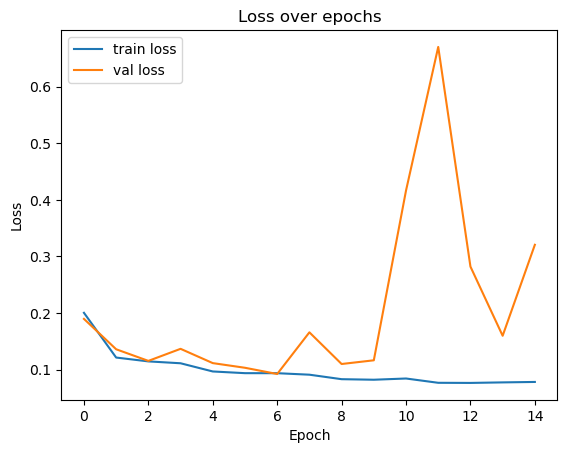

In [25]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Best_loss_plot.png', dpi=300)
plt.show()

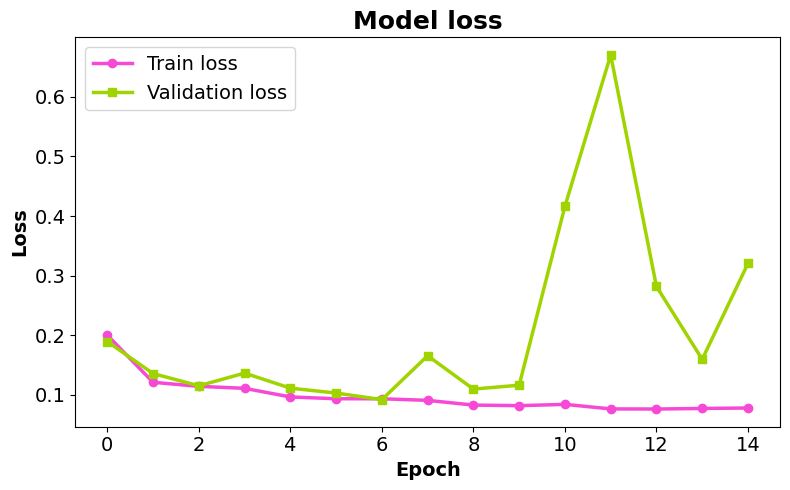

In [63]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history.history['loss'], label='Train loss',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history.history['val_loss'], label='Validation loss',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model loss", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Loss", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Forpres_Best_loss_plot.png', dpi=300, transparent=True)
plt.show()

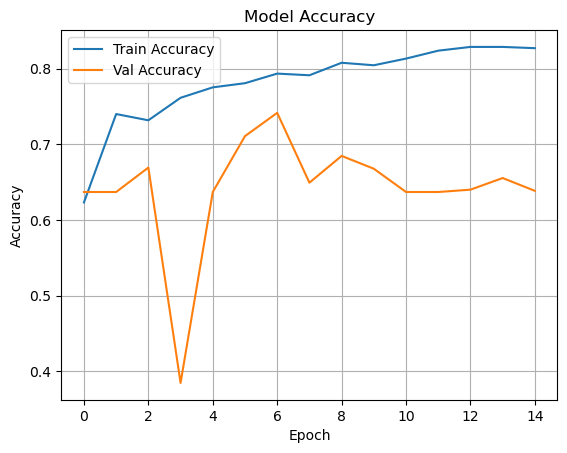

In [29]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Best_Accuracy_plot.png', dpi=300)
plt.show()

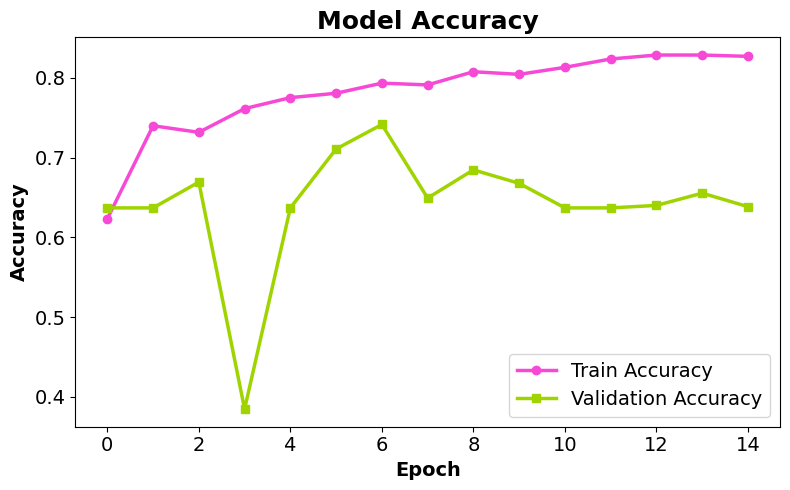

In [65]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history.history['accuracy'], label='Train Accuracy',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model Accuracy", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Accuracy", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Forpres_Best_Accuracy_plot.png', dpi=300, transparent=True)
plt.show()

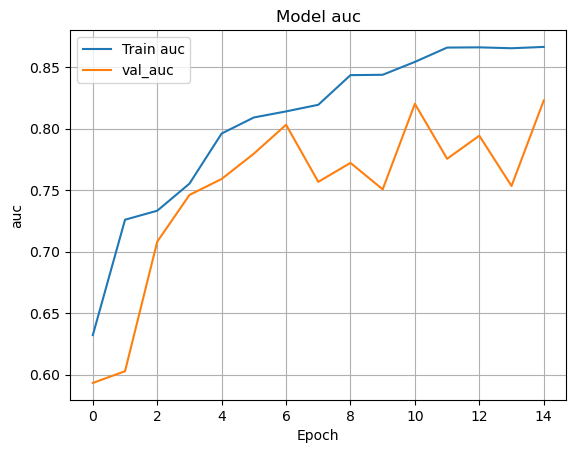

In [33]:
plt.plot(history.history['auc'], label='Train auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Best_AUC_plot.png', dpi=300)
plt.show()

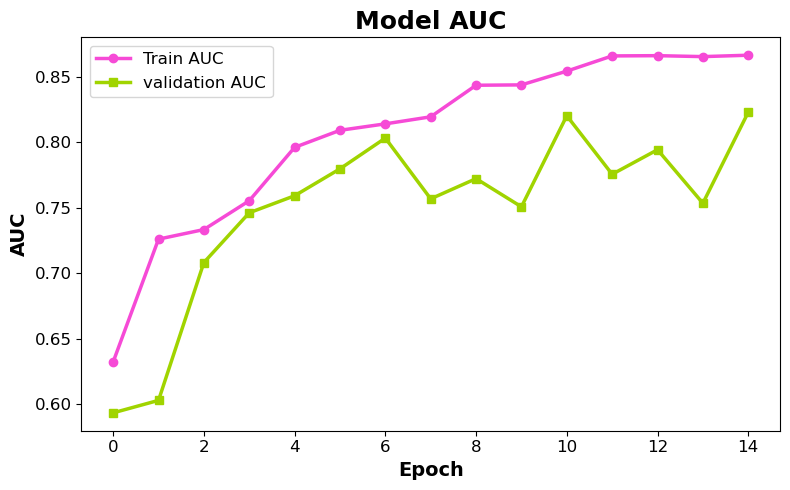

In [67]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history.history['auc'], label='Train AUC',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history.history['val_auc'], label='validation AUC',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model AUC", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("AUC", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Forpres_Best_AUC_plot.png', dpi=300, transparent=True)
plt.show()

In [75]:
# Предсказания на тесте
pred_raw = BestCNNmodel.predict(test_gen)

# Получаем бинарные метки (0 или 1), без вероятностей
pred_classes = (pred_raw > 0.5).astype("int").flatten()

# Получаем настоящие метки
true_labels = test_gen.classes

# Выводим первые 10:
for i in range(10):
    print(f"Image {i+1}: predicted = {pred_classes[i]}, true = {true_labels[i]}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 278ms/step
Image 1: predicted = 0, true = 0
Image 2: predicted = 0, true = 0
Image 3: predicted = 0, true = 1
Image 4: predicted = 1, true = 0
Image 5: predicted = 0, true = 0
Image 6: predicted = 1, true = 1
Image 7: predicted = 0, true = 0
Image 8: predicted = 0, true = 0
Image 9: predicted = 1, true = 1
Image 10: predicted = 0, true = 0


In [76]:
# Получаем вероятности (от 0 до 1)
pred_probs = BestCNNmodel.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(10)

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 304ms/step


Filename True Predicted
0  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
2  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
3  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
6  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

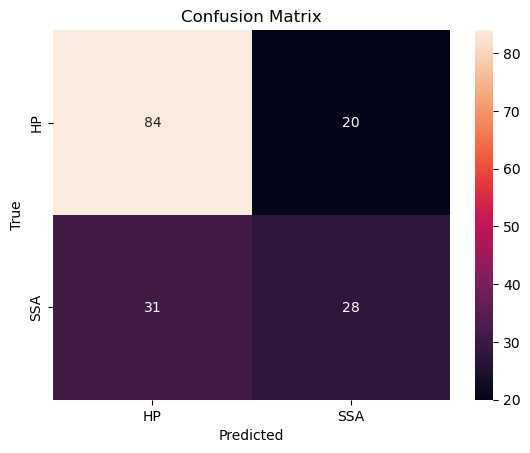

              precision    recall  f1-score   support

          HP       0.73      0.81      0.77       104
         SSA       0.58      0.47      0.52        59

    accuracy                           0.69       163
   macro avg       0.66      0.64      0.65       163
weighted avg       0.68      0.69      0.68       163



In [70]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Best_Confusion_Matrix_plot.png', dpi=300)
plt.show()


print(classification_report(true_labels, pred_labels, target_names=class_names))

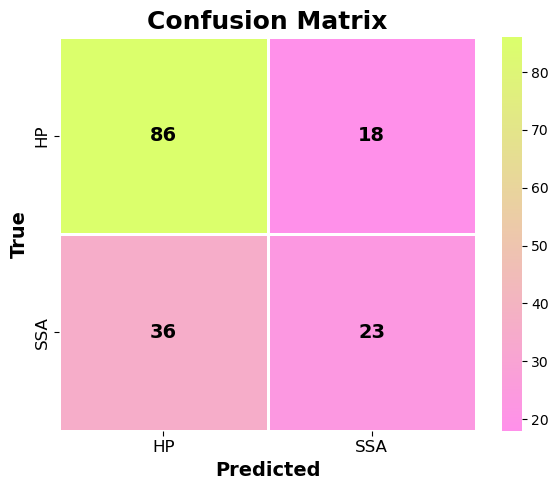

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Создание кастомного градиентного colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#ff90ea", "#dbff6c"])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=custom_cmap,  # градиент
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            linewidths=1,
            linecolor='white',
            annot_kws={"size": 14, "weight": "bold", "color": "black"})

# Оформление
plt.title("Confusion Matrix", fontsize=18, weight='bold')
plt.xlabel("Predicted", fontsize=14, weight='bold')
plt.ylabel("True", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/CNN/Forpres_Best_matrix_plot.png', dpi=300, transparent=True)
plt.show()

# DenseNet121

## Before Fine Tuning 

In [131]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [286]:
# Загружаем предобученную DenseNet121 без "головы"
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Замораживаем базу на первом этапе
base_model.trainable = False

# Добавляем свою классификационную "голову"
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

In [287]:
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return loss


# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=1.5, alpha=0.75), #'binary_crossentropy'
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [137]:
# Колбэки
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('first_densenet_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

In [139]:
# Обучение
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 109s 739ms/step - accuracy: 0.4862 - auc: 0.5114 - loss: 0.1461 - val_accuracy: 0.4462 - val_auc: 0.5727 - val_loss: 0.1292 - learning_rate: 1.0000e-05
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 75s 657ms/step - accuracy: 0.5330 - auc: 0.5926 - loss: 0.1292 - val_accuracy: 0.5969 - val_auc: 0.6745 - val_loss: 0.1070 - learning_rate: 1.0000e-05
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 632ms/step - accuracy: 0.5453 - auc: 0.6468 - loss: 0.1103 - val_accuracy: 0.6400 - val_auc: 0.7290 - val_loss: 0.0994 - learning_rate: 1.0000e-05
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 628ms/step - accuracy: 0.6006 - auc: 0.7149 - loss: 0.1014 - val_accuracy: 0.6723 - val_auc: 0.7534 - val_loss: 0.0943 - learning_rate: 1.0000e-05
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 71s 621ms/step - accuracy: 0.6465 - auc: 0.7752 - loss: 0.0898 - val_accuracy: 0.6738 - val_auc: 0.8013 - val_loss: 0.0838 - learning_rate: 1.0000e-05
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 69s 

In [140]:
from tensorflow.keras.models import load_model

# Заново определить функцию потерь
def focal_loss(gamma=1.5, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return loss

model = load_model(
    'first_densenet_model.keras',
    custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.75)}
)

In [141]:
# Получаем вероятности (от 0 до 1)
pred_probs = model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(10)

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 874ms/step


Filename True Predicted
0  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
2  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

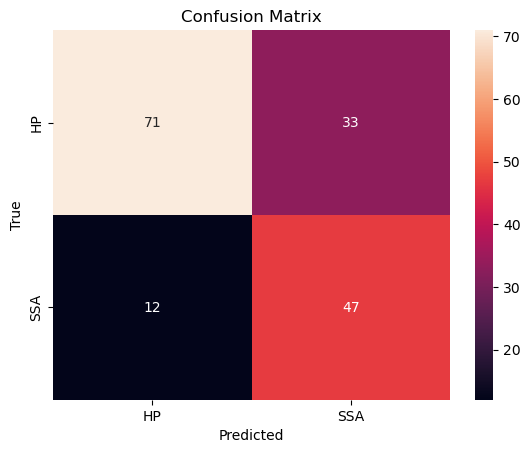

              precision    recall  f1-score   support

          HP       0.86      0.68      0.76       104
         SSA       0.59      0.80      0.68        59

    accuracy                           0.72       163
   macro avg       0.72      0.74      0.72       163
weighted avg       0.76      0.72      0.73       163



In [142]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

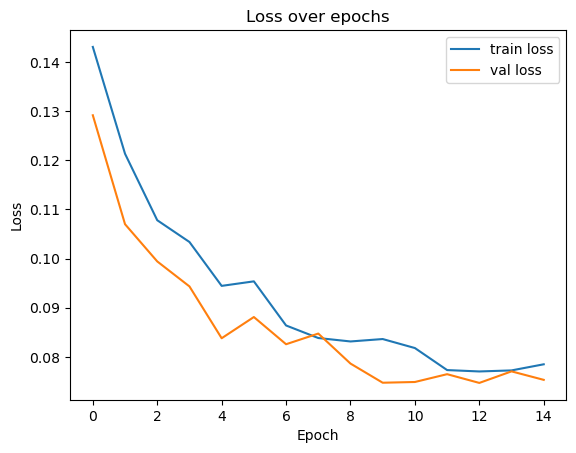

In [143]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Loss_plot.png', dpi=300)
plt.show()

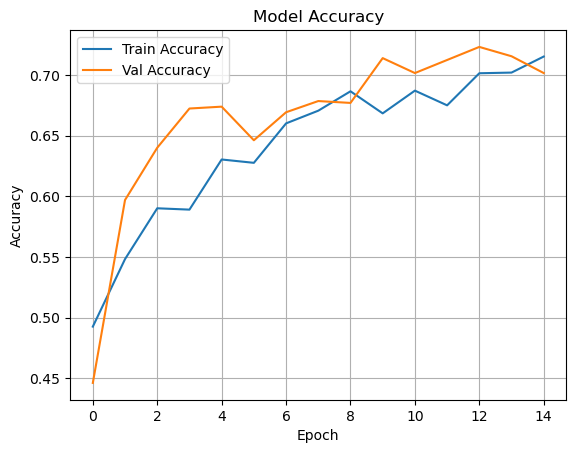

In [144]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Accuracy_plot.png', dpi=300)
plt.show()

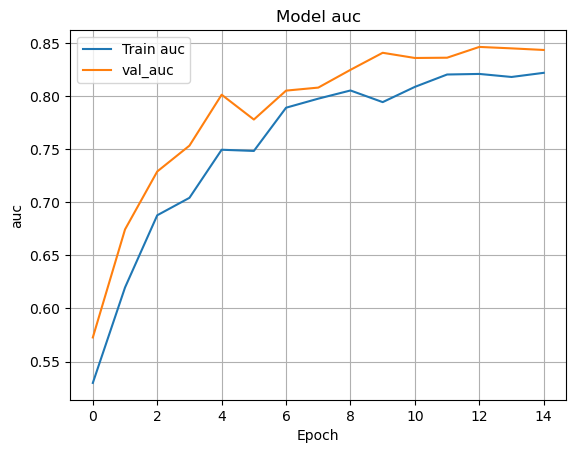

In [145]:
plt.plot(history.history['auc'], label='Train auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_AUC_plot.png', dpi=300)
plt.show()

## After Fine-tuning

In [159]:
# === Этап 2: Fine-tuning (разморозка последних 30 слоёв) ===
base_model.trainable = True

# Замораживаем все слои, кроме последних 30
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [161]:
early_stop = EarlyStopping(
    monitor='val_auc',    
    patience=3,                # Сколько эпох ждать без заметного улучшения
    min_delta=0.01,            # Минимальное улучшение между эпохами
    restore_best_weights=True,
    verbose=1
)


# Перекомпиляция с меньшим learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=1.5, alpha=0.75), #'binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

Epoch 1/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 98s 674ms/step - accuracy: 0.6908 - auc: 0.8093 - loss: 0.0806 - val_accuracy: 0.7323 - val_auc: 0.8549 - val_loss: 0.0712 - learning_rate: 1.0000e-05
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 67s 590ms/step - accuracy: 0.7051 - auc: 0.8144 - loss: 0.0809 - val_accuracy: 0.7246 - val_auc: 0.8437 - val_loss: 0.0754 - learning_rate: 1.0000e-05
Epoch 3/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 69s 601ms/step - accuracy: 0.7190 - auc: 0.8376 - loss: 0.0740 - val_accuracy: 0.7231 - val_auc: 0.8516 - val_loss: 0.0734 - learning_rate: 1.0000e-05
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 69s 602ms/step - accuracy: 0.7350 - auc: 0.8464 - loss: 0.0702 - val_accuracy: 0.7400 - val_auc: 0.8650 - val_loss: 0.0685 - learning_rate: 5.0000e-06
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 69s 608ms/step - accuracy: 0.7214 - auc: 0.8364 - loss: 0.0758 - val_accuracy: 0.7000 - val_auc: 0.8443 - val_loss: 0.0747 - learning_rate: 5.0000e-06
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 66s 5

In [164]:
model.save('first_finetuned_densenet_model.keras')

In [165]:
model = load_model(
    'first_finetuned_densenet_model.keras',
    custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.75)}
)

In [166]:
# Получаем вероятности (от 0 до 1)
pred_probs = model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 924ms/step


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

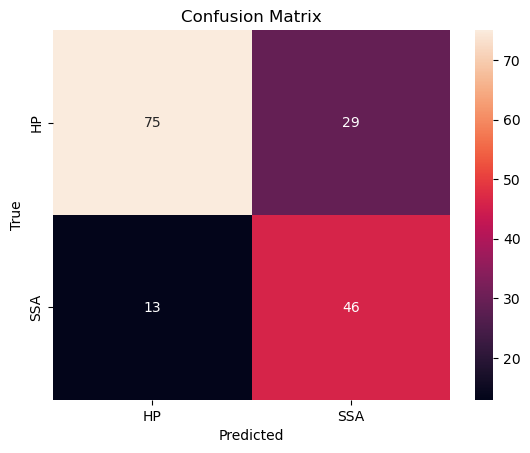

              precision    recall  f1-score   support

          HP       0.85      0.72      0.78       104
         SSA       0.61      0.78      0.69        59

    accuracy                           0.74       163
   macro avg       0.73      0.75      0.73       163
weighted avg       0.77      0.74      0.75       163



In [167]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/After_fine_tuning_DenseNet_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))


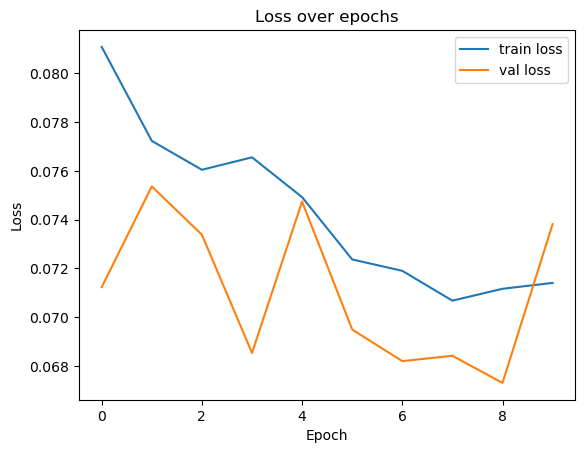

In [168]:
plt.plot(history_stage2.history['loss'], label='train loss')
plt.plot(history_stage2.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/After_fine_tuning_DenseNet_Loss_plot.png', dpi=300)
plt.show()

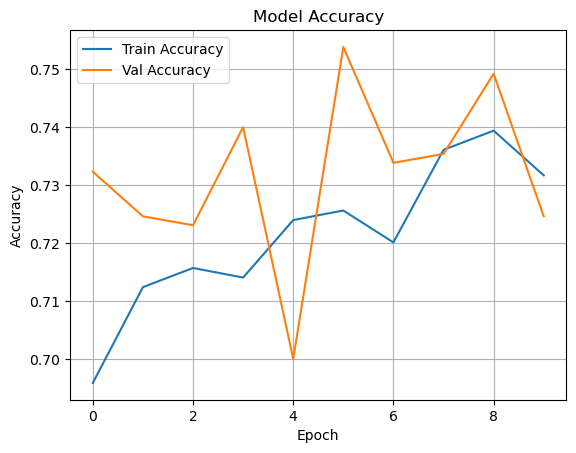

In [169]:
plt.plot(history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/After_fine_tuning_DenseNet_Accuracy_plot.png', dpi=300)
plt.show()

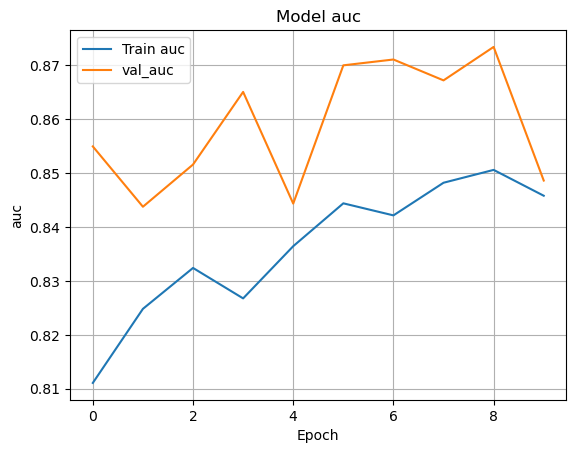

In [170]:
plt.plot(history_stage2.history['auc'], label='Train auc')
plt.plot(history_stage2.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/After_fine_tuning_DenseNet_AUC_plot.png', dpi=300)
plt.show()

# DenseNet121 + RandomSearch

In [165]:
from keras_tuner import RandomSearch
import keras_tuner as kt
from tensorflow.keras import layers, models

def build_feature_extraction_model(hp):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3), name='densenet121_base')
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('dense_units', 64, 256, step=64))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-5])),
        loss=focal_loss(gamma=hp.Choice('gamma', [1.5, 2.0]), alpha=hp.Choice('alpha', [0.5, 0.75])),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model
    
early_stop = EarlyStopping(
    monitor='val_loss',        # Можно также 'val_accuracy'
    patience=3,                # Сколько эпох ждать без заметного улучшения
    min_delta=0.01,           # Минимальное улучшение между эпохами
    restore_best_weights=True,
    verbose=1
)

tuner = RandomSearch(
    build_feature_extraction_model,
    objective='val_auc',
    max_trials=10,
    directory='densenet_tuning',
    project_name='feature_extraction'
)

tuner.search(train_gen, validation_data=val_gen, epochs=11, callbacks=[early_stop])

Reloading Tuner from densenet_tuning\feature_extraction\tuner0.json


In [234]:
# best_model = tuner.get_best_models(1)[0]
# best_model.save('best_densenet_model.keras')

best_hp = tuner.get_best_hyperparameters(1)[0]

In [238]:
print(best_hp.values)

{'dense_units': 128, 'dropout_rate': 0.2, 'lr': 0.0001, 'gamma': 1.0, 'alpha': 0.75}


In [177]:
# Собираем данные по всем триалам
trials_data = []

for trial in tuner.oracle.trials.values():
    hp_values = trial.hyperparameters.values
    metrics = trial.metrics.get_best_value('val_auc')  # целевая метрика

    row = {
        'Trial_ID': trial.trial_id,
        'val_auc': metrics,
        'val_loss': trial.metrics.get_last_value('val_loss'),
        'accuracy': trial.metrics.get_last_value('accuracy'),
        'val_accuracy': trial.metrics.get_last_value('val_accuracy'),
        'loss': trial.metrics.get_last_value('loss'),
        **hp_values
    }
    trials_data.append(row)

# Преобразуем в DataFrame
df = pd.DataFrame(trials_data)

# Сохраняем в Excel
df.to_excel("C:/Users/user/Desktop/Tensor-FLow Project/DenseNetRandomSearch2.xlsx", index=False)

# Показываем как таблицу (если в Jupyter/Colab)
from IPython.display import display
display(df)

Trial_ID   val_auc  val_loss  accuracy  val_accuracy      loss  dense_units  \
0       00  0.765194  0.197578  0.709091      0.412308  0.103610           64   
1       01  0.749616  0.085436  0.471074      0.612308  0.076164           64   
2       02  0.771212  0.210655  0.721763      0.636923  0.102345          128   
3       03  0.752180  0.146405  0.697521      0.415385  0.078662          128   
4       04  0.695847  0.248857  0.741047      0.367692  0.068228          256   
5       05  0.804251  0.136593  0.697521      0.738462  0.108894          128   
6       06  0.759063  0.088734  0.402204      0.663077  0.068802           64   
7       07  0.756387  0.092968  0.719559      0.644615  0.079551          256   
8       08  0.739151  0.072706  0.651240      0.687692  0.066825          256   
9       09  0.733174  0.090877  0.476584      0.607692  0.077513          192   

   dropout_rate      lr  gamma  alpha  
0           0.3  0.0001    1.5   0.50  
1           0.3  0.0001    1.0   0.90  
2           0.4  0.0001    1.5   0.50  
3           0.3  0.0001    2.0   0.50  
4           0.2  0.0001    2.0   0.50  
5           0.2  0.0001    1.0   0.75  
6           0.4  0.0001    1.5   0.90  
7           0.4  0.0001    2.0   0.50  
8           0.4  0.0001    2.0   0.75  
9           0.3  0.0001    1.0   0.90

In [179]:
corrDense_matrix = fine_df.corr()
corrDense_matrix

unfreeze_layers            lr   val_auc  val_accuracy  \
unfreeze_layers     1.000000e+00  9.484793e-17  0.723991      0.139192   
lr                  9.484793e-17  1.000000e+00 -0.095122     -0.518356   
val_auc             7.239909e-01 -9.512182e-02  1.000000      0.680737   
val_accuracy        1.391924e-01 -5.183556e-01  0.680737      1.000000   
val_loss           -6.077970e-01 -3.098569e-01 -0.865234     -0.360845   

                 val_loss  
unfreeze_layers -0.607797  
lr              -0.309857  
val_auc         -0.865234  
val_accuracy    -0.360845  
val_loss         1.000000

## Fine-tuning 

### (было 1,5 0,75) сейчас пробую 1.0 0.75 чтобы по феншую (чтобы вернутть старый проект, директорию и модель нужно убрать _new_ из всех названий), старый AUC 0.91 loss 0.1

In [358]:
from tensorflow.keras.models import load_model

base_model_full = load_model(
    'best_densenet_model.keras',
    custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)}
)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [247]:
from tensorflow.keras.models import clone_model

def build_fine_tune_model(hp):
    from tensorflow.keras.models import clone_model

    # Клонируем модель и загружаем веса
    model = clone_model(base_model_full)
    model.set_weights(base_model_full.get_weights())

    # Определяем, сколько слоёв разморозить
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=20, max_value=100, step=20)

    # Выбираем только сверточные и нормализующие слои из "базы"
    base_layers = [layer for layer in model.layers if any(substr in layer.name for substr in ['conv', 'bn', 'pool'])]

    # Размораживаем последние N слоёв
    for layer in base_layers[-unfreeze_layers:]:
        layer.trainable = True
    for layer in base_layers[:-unfreeze_layers]:
        layer.trainable = False

    # Компилируем модель
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-5, 3e-5])),
        loss=focal_loss(gamma=1.0, alpha=0.75),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

In [261]:
fine_tuner_new = RandomSearch(
    build_fine_tune_model,
    objective='val_auc',
    max_trials=10,
    directory='densenet_tuning_new_',
    project_name='fine_tuning_new_'
)

fine_tuner_new.search(train_gen, validation_data=val_gen, epochs=12)

# , callbacks=[early_stop]

Trial 9 Complete [00h 21m 16s]
val_auc: 0.9137957692146301

Best val_auc So Far: 0.9347212314605713
Total elapsed time: 07h 23m 23s


In [267]:
best_finetuned_model = fine_tuner.get_best_models(1)[0]
best_finetuned_model.save('best_densenet_new_finetuned_model.keras')

best_fine_hp = fine_tuner.get_best_hyperparameters(1)[0]
print(best_fine_hp.values)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 150 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


{'unfreeze_layers': 80, 'lr': 3e-05}


In [268]:
# Собираем данные по всем триалам
trials_data = []

for trial in fine_tuner_new.oracle.trials.values():
    hp_values = trial.hyperparameters.values
    metrics = trial.metrics.get_best_value('val_auc')  # целевая метрика

    row = {
        'Trial_ID': trial.trial_id,
        'val_auc': metrics,
        'val_loss': trial.metrics.get_last_value('val_loss'),
        'accuracy': trial.metrics.get_last_value('accuracy'),
        'val_accuracy': trial.metrics.get_last_value('val_accuracy'),
        'loss': trial.metrics.get_last_value('loss'),
        **hp_values
    }
    trials_data.append(row)

# Преобразуем в DataFrame
df = pd.DataFrame(trials_data)

# Сохраняем в Excel
df.to_excel("C:/Users/user/Desktop/Tensor-FLow Project/DenseNetRandomSearch2_new_.xlsx", index=False)

# Показываем как таблицу (если в Jupyter/Colab)
from IPython.display import display
display(df)

Trial_ID   val_auc  val_loss  accuracy  val_accuracy      loss  \
0       00  0.906099  0.084030  0.779614      0.813846  0.098085   
1       01  0.918202  0.080719  0.822039      0.827692  0.080384   
2       02  0.928432  0.071459  0.837466      0.826154  0.068637   
3       03  0.932904  0.070007  0.866116      0.836923  0.057302   
4       04  0.934721  0.070707  0.863361      0.836923  0.055259   
5       05  0.924036  0.080436  0.864463      0.846154  0.055364   
6       06  0.912383  0.078714  0.771901      0.818462  0.103399   
7       07  0.910393  0.081822  0.814876      0.821538  0.084517   
8       08  0.913796  0.083049  0.812672      0.816923  0.084848   

   unfreeze_layers       lr  
0               20  0.00001  
1               20  0.00003  
2               40  0.00003  
3               80  0.00003  
4              100  0.00003  
5               60  0.00003  
6               40  0.00001  
7              100  0.00001  
8               80  0.00001

In [24]:
from tensorflow.keras.models import load_model

# Загружаем модель без custom_objects
model = load_model('best_densenet_new_finetuned_model.keras', compile=False)

In [26]:
# Компилируем модель заново
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Оценка
loss, accuracy, auc = model.evaluate(val_gen)
print(f"Loss: {loss:.4f} | Accuracy: {accuracy:.4f} | AUC: {auc:.4f}")

NameError: name 'Adam' is not defined

In [281]:
# Получаем вероятности (от 0 до 1)
pred_probs = model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step 


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

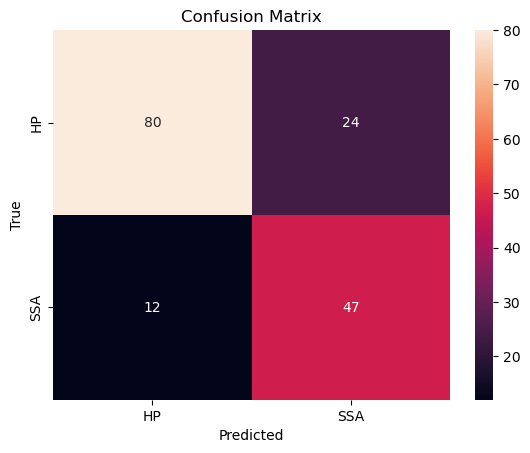

              precision    recall  f1-score   support

          HP       0.87      0.77      0.82       104
         SSA       0.66      0.80      0.72        59

    accuracy                           0.78       163
   macro avg       0.77      0.78      0.77       163
weighted avg       0.79      0.78      0.78       163



In [282]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/After_fine_tuning_DenseNet_new_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

# DenseNet Best trial

In [16]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle


# Загружаем предобученную DenseNet121 без "головы"
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Замораживаем базу на первом этапе
base_model.trainable = False

# Добавляем свою классификационную "голову"
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return loss


# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=focal_loss(gamma=1.0, alpha=0.75), #'binary_crossentropy'
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Колбэки
callbacks = [
    ModelCheckpoint('FINAL_densenet_model_with_history.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Обучение
history_Densebefore = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

with open('FINAL_densenet_history.pkl', 'wb') as f:
    pickle.dump(history_Densebefore.history, f)


results.head(10)

C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 79s 551ms/step - accuracy: 0.6675 - auc: 0.7107 - loss: 0.1394 - val_accuracy: 0.8108 - val_auc: 0.8861 - val_loss: 0.1094 - learning_rate: 1.0000e-04
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 59s 519ms/step - accuracy: 0.7508 - auc: 0.8447 - loss: 0.1004 - val_accuracy: 0.7846 - val_auc: 0.8911 - val_loss: 0.0857 - learning_rate: 1.0000e-04
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 60s 522ms/step - accuracy: 0.7717 - auc: 0.8757 - loss: 0.0861 - val_accuracy: 0.7800 - val_auc: 0.9012 - val_loss: 0.0809 - learning_rate: 1.0000e-04
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 59s 517ms/step - accuracy: 0.7904 - auc: 0.8903 - loss: 0.0809 - val_accuracy: 0.7815 - val_auc: 0.9170 - val_loss: 0.0745 - learning_rate: 1.0000e-04
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 56s 494ms/step - accuracy: 0.8251 - auc: 0.9207 - loss: 0.0697 - val_accuracy: 0.8138 - val_auc: 0.9063 - val_loss: 0.0841 - learning_rate: 1.0000e-04
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 5

NameError: name 'results' is not defined

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

model = load_model(
    'FINAL_densenet_model_with_history.keras',
    custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)}
)

with open('FINAL_densenet_history.pkl', 'rb') as f:
    history_Densebefore = pickle.load(f)

# Получаем вероятности (от 0 до 1)
pred_probs = model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})


C:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 742ms/step


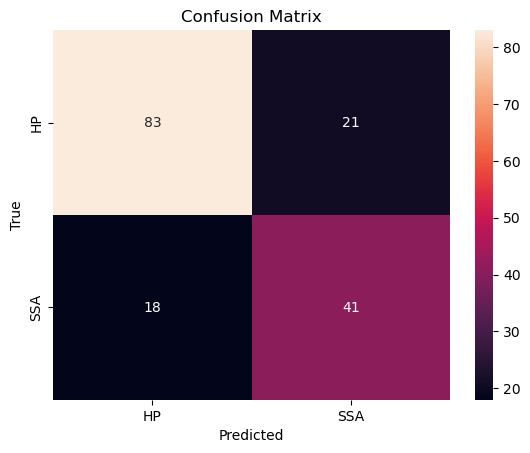

              precision    recall  f1-score   support

          HP       0.82      0.80      0.81       104
         SSA       0.66      0.69      0.68        59

    accuracy                           0.76       163
   macro avg       0.74      0.75      0.74       163
weighted avg       0.76      0.76      0.76       163



In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_before_finetuning_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

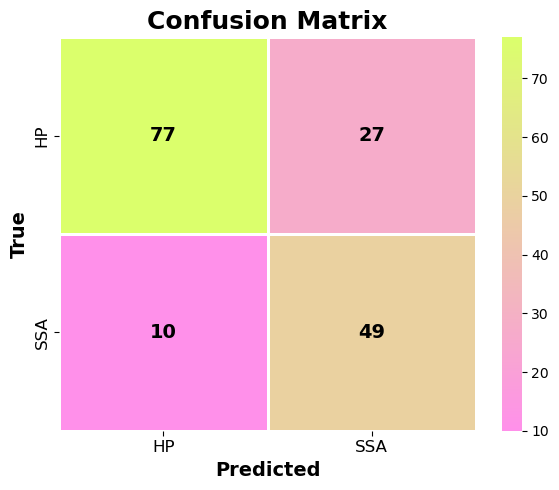

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Создание кастомного градиентного colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#ff90ea", "#dbff6c"])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=custom_cmap,  # градиент
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            linewidths=1,
            linecolor='white',
            annot_kws={"size": 14, "weight": "bold", "color": "black"})

# Оформление
plt.title("Confusion Matrix", fontsize=18, weight='bold')
plt.xlabel("Predicted", fontsize=14, weight='bold')
plt.ylabel("True", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Denseforpres_confision_matrix_plot.png',
            dpi=300, transparent=True)
plt.show()

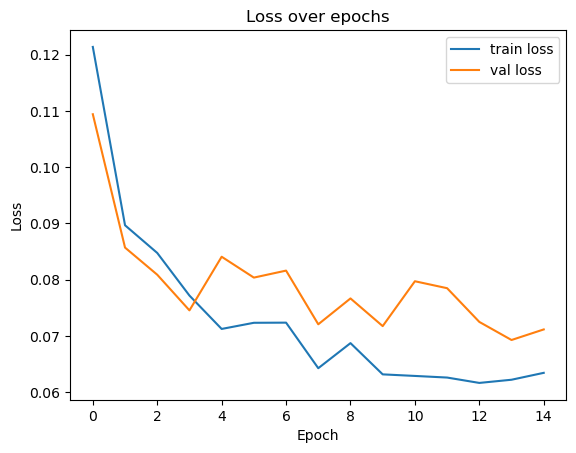

In [26]:
plt.plot(history_Densebefore['loss'], label='train loss')
plt.plot(history_Densebefore['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Final/FINAL_DenseNet_before_finetuning_Loss_plot.png', dpi=300)
plt.show()

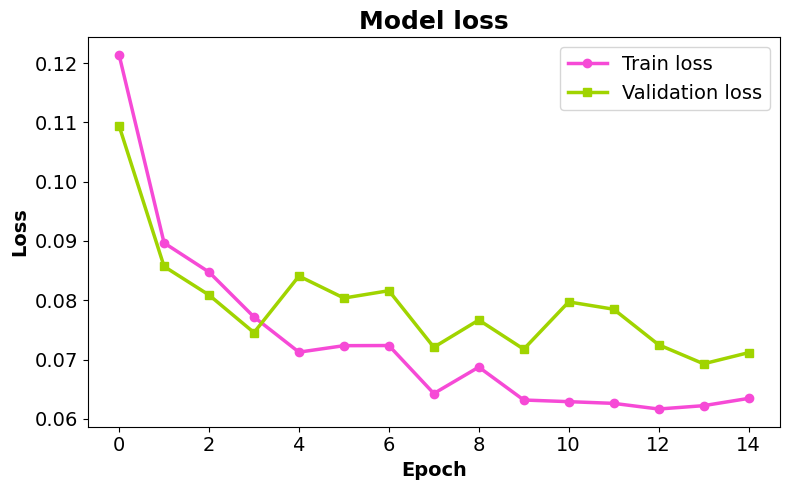

In [30]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_Densebefore['loss'], label='Train loss',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_Densebefore['val_loss'], label='Validation loss',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model loss", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Loss", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Denseforpres_loss_plot.png', dpi=300, transparent=True)
plt.show()

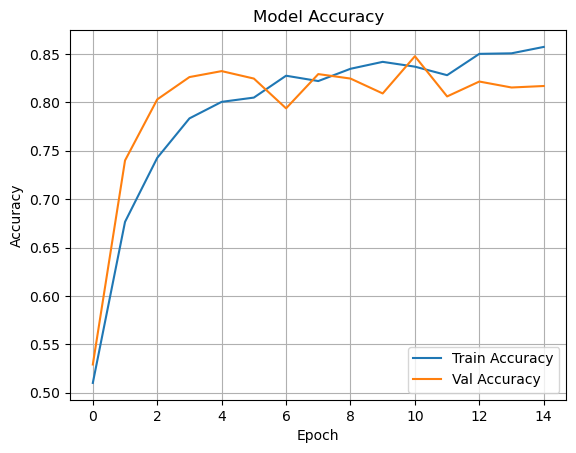

In [367]:
plt.plot(history_Densebefore.history['accuracy'], label='Train Accuracy')
plt.plot(history_Densebefore.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Final/FINAL_DenseNet_before_finetuning_Accuracy_plot.png', dpi=300)
plt.show()

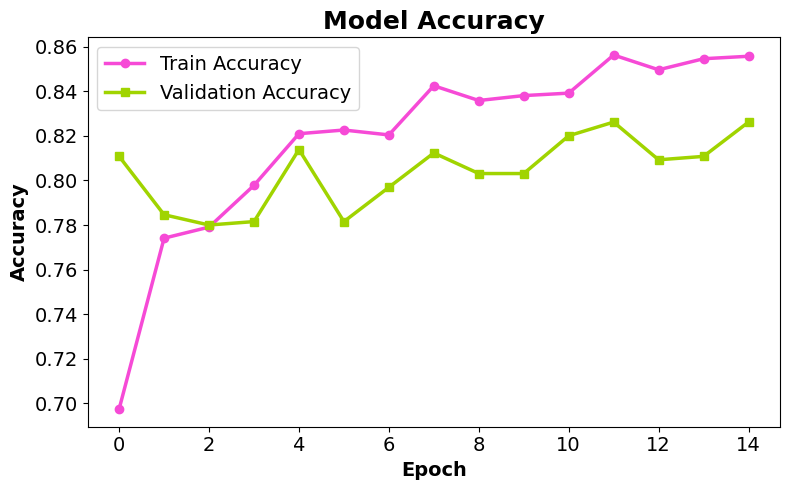

In [32]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_Densebefore['accuracy'], label='Train Accuracy',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_Densebefore['val_accuracy'], label='Validation Accuracy',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model Accuracy", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Accuracy", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Denseforpres_Accuracy_plot.png', dpi=300, transparent=True)
plt.show()

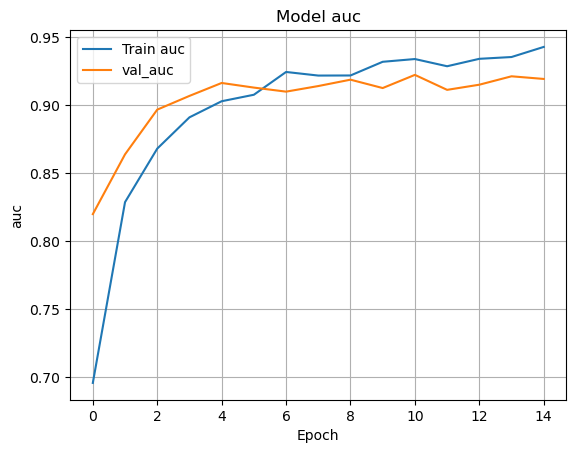

In [369]:
plt.plot(history.history['auc'], label='Train auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Final/FINAL_DenseNet_before_finetuning_AUC_plot.png', dpi=300)
plt.show()

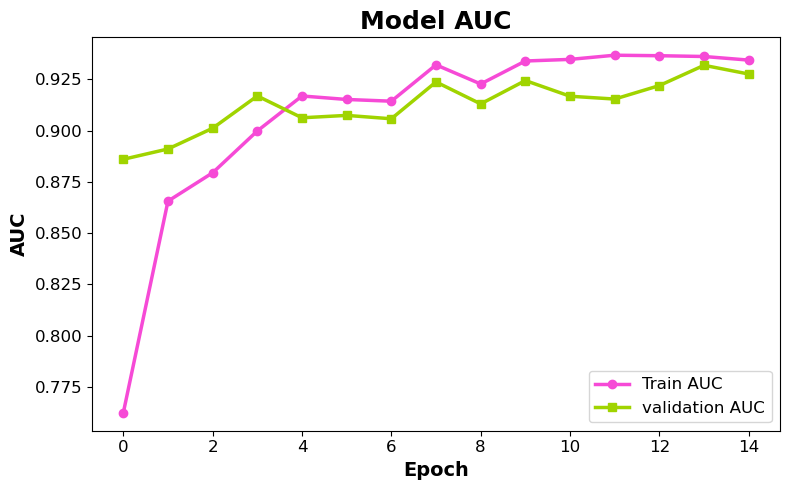

In [34]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_Densebefore['auc'], label='Train AUC',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_Densebefore['val_auc'], label='validation AUC',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model AUC", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("AUC", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Denseforpres_AUC_plot.png', dpi=300, transparent=True)
plt.show()

## DenseNet Best trial fine-tuning

In [36]:
# === Этап 2: Fine-tuning (разморозка последних 30 слоёв) ===
base_model.trainable = True

# Замораживаем все слои, кроме последних 30
for layer in base_model.layers[:-100]:
    layer.trainable = False

# early_stop = EarlyStopping(
#     monitor='val_auc',    
#     patience=3,                # Сколько эпох ждать без заметного улучшения
#     min_delta=0.01,            # Минимальное улучшение между эпохами
#     restore_best_weights=True,
#     verbose=1
# )


# Перекомпиляция с меньшим learning rate
model.compile(
    optimizer=Adam(learning_rate=3e-05),
    loss=focal_loss(gamma=1.0, alpha=0.75), #'binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Продолжаем обучение уже всей модели
history_afterfine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

with open('afterFINAL_densenet_history.pkl', 'wb') as k:
    pickle.dump(history_afterfine.history, k)

model.save('FINAL_finetuned_densenet_model.keras')

Epoch 1/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 80s 559ms/step - accuracy: 0.8457 - auc: 0.9374 - loss: 0.0626 - val_accuracy: 0.8046 - val_auc: 0.9163 - val_loss: 0.0766 - learning_rate: 3.0000e-05
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 53s 468ms/step - accuracy: 0.8823 - auc: 0.9493 - loss: 0.0576 - val_accuracy: 0.8077 - val_auc: 0.9217 - val_loss: 0.0744 - learning_rate: 3.0000e-05
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - accuracy: 0.8448 - auc: 0.9376 - loss: 0.0631 - val_accuracy: 0.8323 - val_auc: 0.9245 - val_loss: 0.0739 - learning_rate: 3.0000e-05
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - accuracy: 0.8610 - auc: 0.9474 - loss: 0.0571 - val_accuracy: 0.8231 - val_auc: 0.9224 - val_loss: 0.0738 - learning_rate: 3.0000e-05
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - accuracy: 0.8758 - auc: 0.9527 - loss: 0.0544 - val_accuracy: 0.8092 - val_auc: 0.9218 - val_loss: 0.0743 - learning_rate: 3.0000e-05
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 52s 4

In [38]:
model = load_model(
    'FINAL_finetuned_densenet_model.keras',
    custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)}
)

with open('afterFINAL_densenet_history.pkl', 'rb') as k:
    history_afterfine = pickle.load(k)

In [40]:
# Получаем вероятности (от 0 до 1)
pred_probs = model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 639ms/step


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

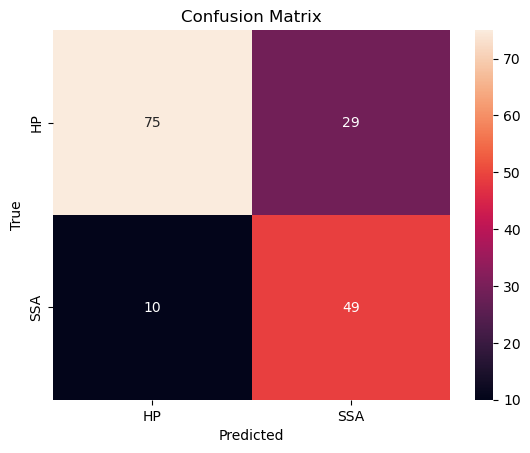

              precision    recall  f1-score   support

          HP       0.88      0.72      0.79       104
         SSA       0.63      0.83      0.72        59

    accuracy                           0.76       163
   macro avg       0.76      0.78      0.75       163
weighted avg       0.79      0.76      0.77       163



In [69]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

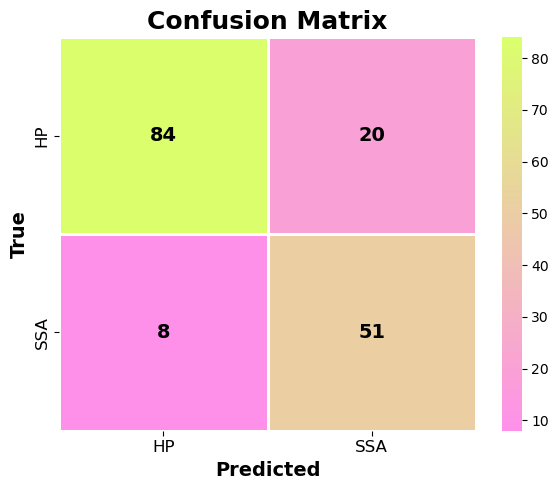

In [80]:
# Создание кастомного градиентного colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#ff90ea", "#dbff6c"])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=custom_cmap,  # градиент
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            linewidths=1,
            linecolor='white',
            annot_kws={"size": 14, "weight": "bold", "color": "black"})

# Оформление
plt.title("Confusion Matrix", fontsize=18, weight='bold')
plt.xlabel("Predicted", fontsize=14, weight='bold')
plt.ylabel("True", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Aftertune_Denseforpres_confision_matrix_plot.png',
            dpi=300, transparent=True)
plt.show()

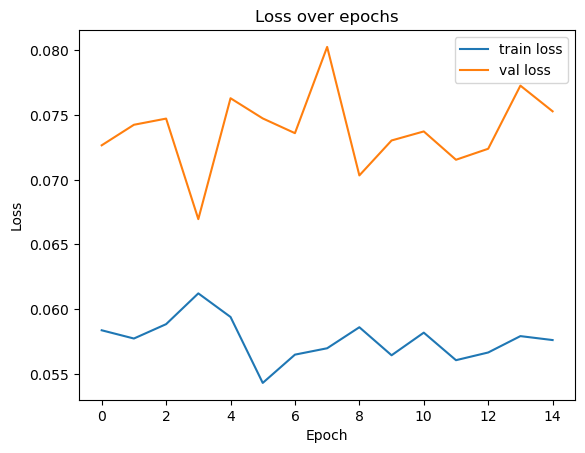

In [322]:
plt.plot(history_stage3.history['loss'], label='train loss')
plt.plot(history_stage3.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Final/FINAL_DenseNet_Loss_plot.png', dpi=300)
plt.show()

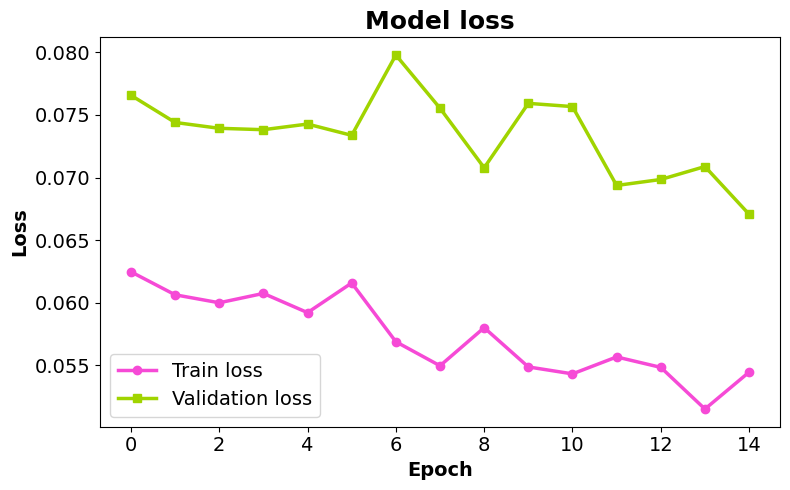

In [44]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_afterfine['loss'], label='Train loss',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_afterfine['val_loss'], label='Validation loss',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model loss", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Loss", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Aftertune_Denseforpres_loss_plot.png', dpi=300, transparent=True)
plt.show()

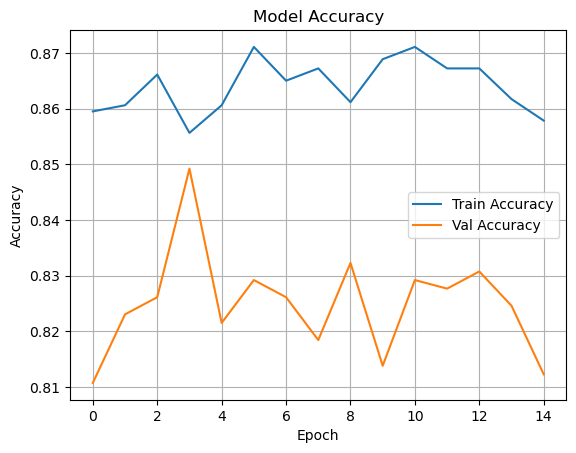

In [323]:
plt.plot(history_stage3.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Final/FINAL_DenseNet_Accuracy_plot.png', dpi=300)
plt.show()

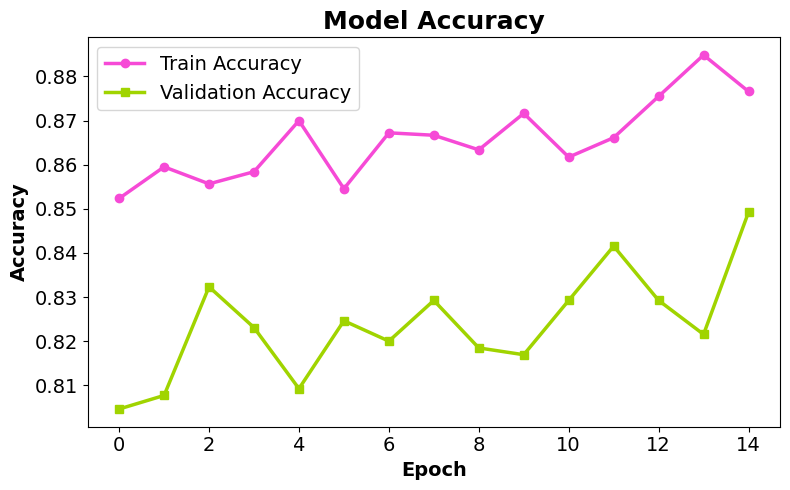

In [46]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_afterfine['accuracy'], label='Train Accuracy',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_afterfine['val_accuracy'], label='Validation Accuracy',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model Accuracy", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Accuracy", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Aftertune_Denseforpres_Accuracy_plot.png', dpi=300, transparent=True)
plt.show()

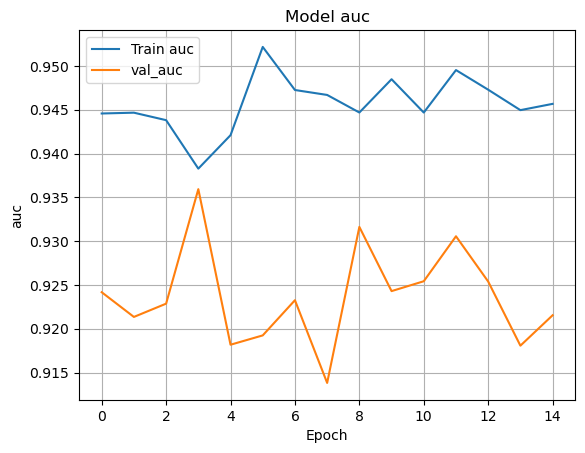

In [324]:
plt.plot(history_stage3.history['auc'], label='Train auc')
plt.plot(history_stage3.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/DenseNet_Final/FINAL_DenseNet_AUC_plot.png', dpi=300)
plt.show()

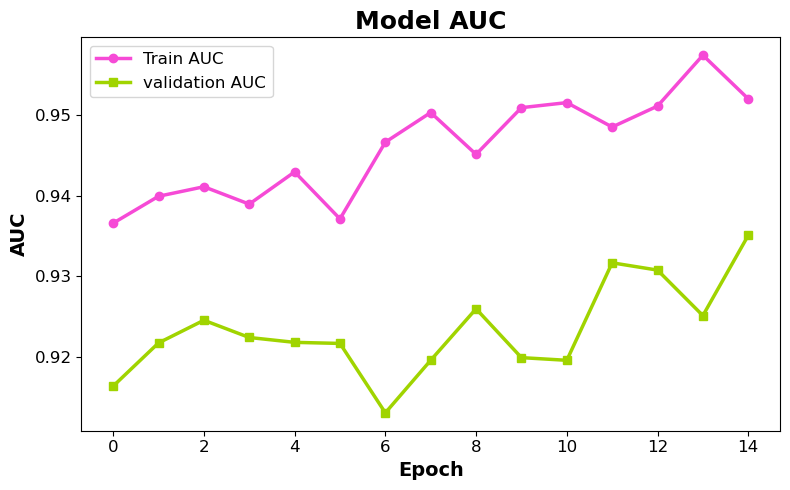

In [48]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_afterfine['auc'], label='Train AUC',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_afterfine['val_auc'], label='validation AUC',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model AUC", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("AUC", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/DenseNet/Aftertune_Denseforpres_AUC_plot.png', dpi=300, transparent=True)
plt.show()

In [330]:
!pip install tf-keras-vis


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [332]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input

In [334]:
# Модификатор: замена softmax/sigmoid на линейную функцию (для GradCAM)
modifier = ReplaceToLinear()

# Подготовка функции подсчета score
def binary_score(class_index):
    def score(output):
        return output[:, class_index]
    return score

# Загрузи модель
model = load_model('FINAL_finetuned_densenet_model.keras',
                   custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)})

# Укажи последний сверточный слой модели (DenseNet121)
# Обычно это: 'conv5_block16_2_conv' — можно проверить через model.summary()
gradcam = Gradcam(model, model_modifier=modifier, clone=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


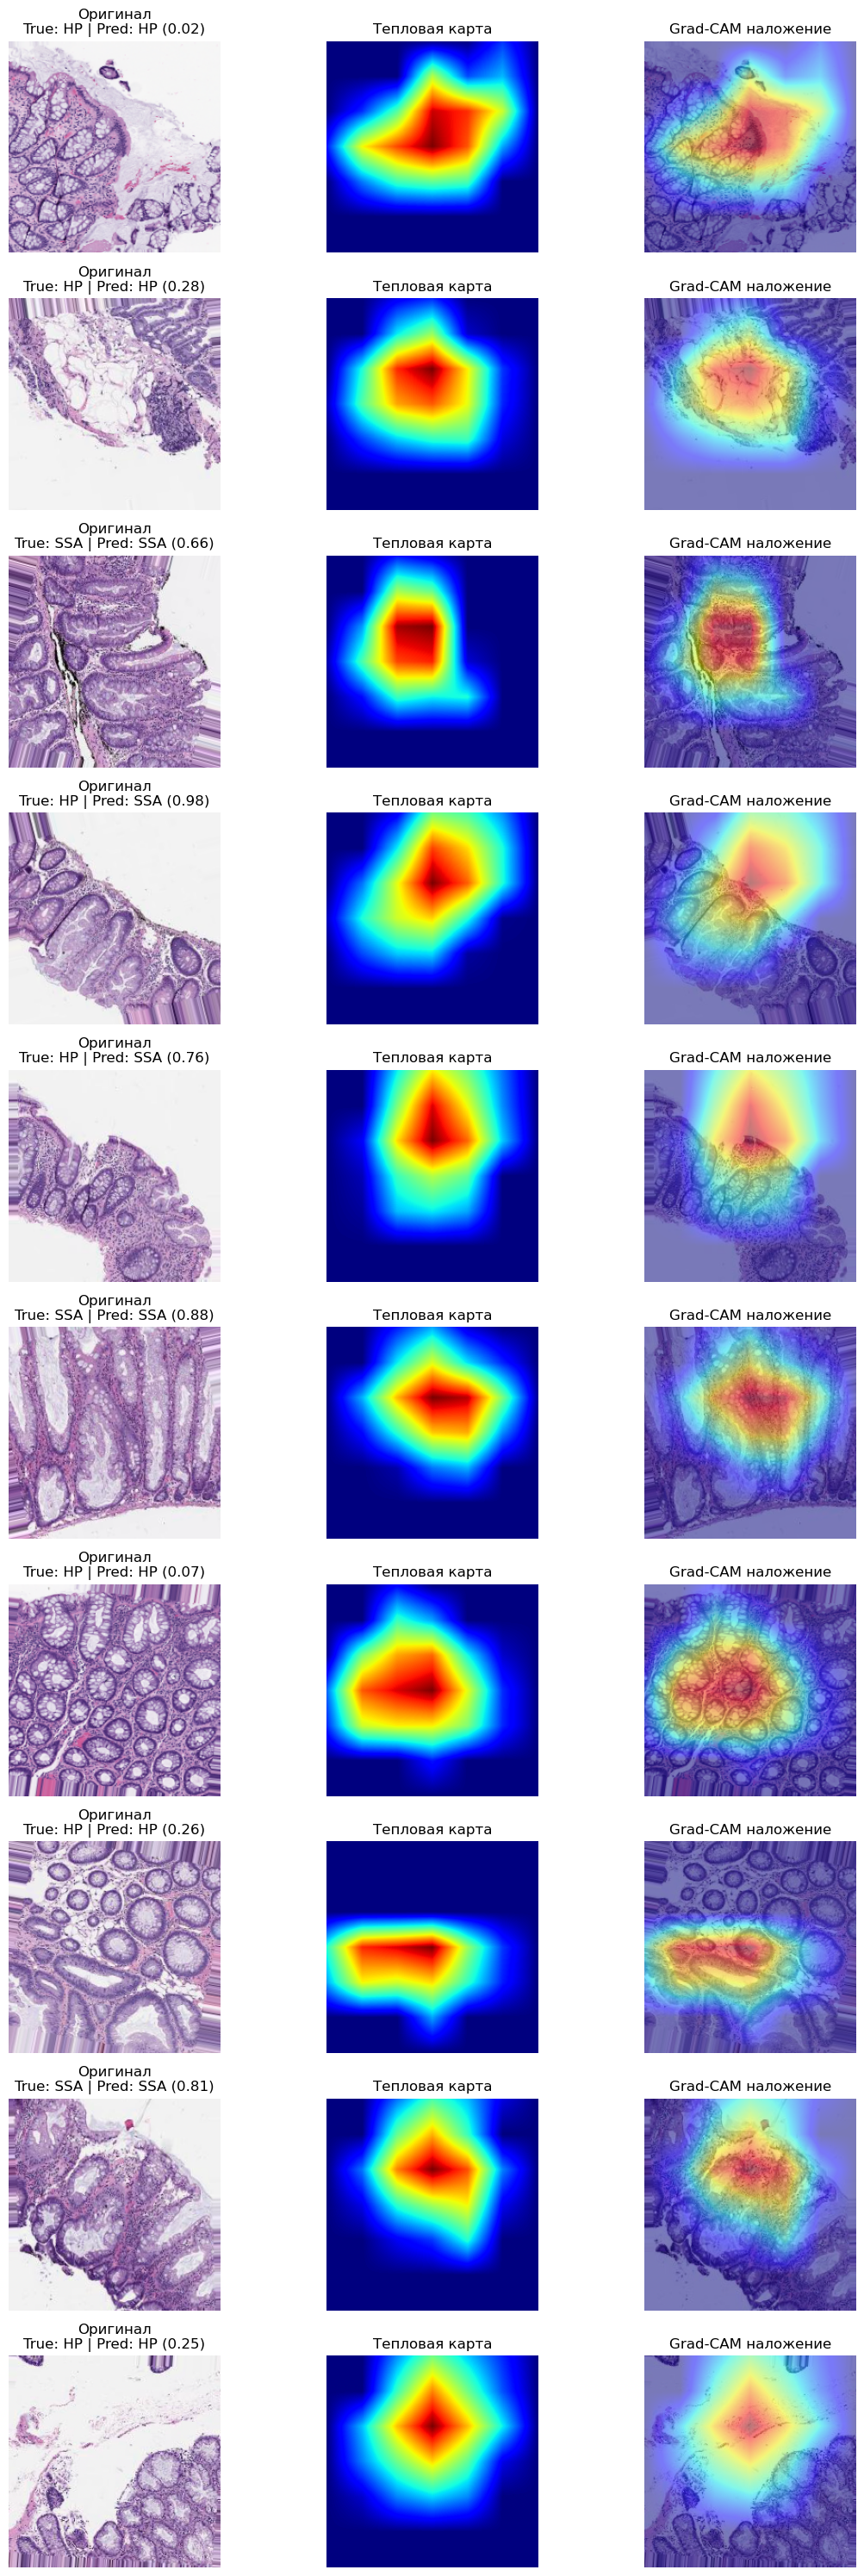

In [377]:
n_images = 10
batch_x, batch_y = test_gen[0]  # получаем изображения и метки
batch_pred_probs = model.predict(batch_x)
batch_pred_labels = (batch_pred_probs > 0.5).astype(int).flatten()

class_names = list(test_gen.class_indices.keys())

fig, axes = plt.subplots(n_images, 3, figsize=(12, n_images * 3))

for i in range(n_images):
    img = batch_x[i]
    img_input = np.expand_dims(img.copy(), axis=0)
    img_input = preprocess_input(img_input)

    cam = gradcam(binary_score(0), img_input, penultimate_layer='conv5_block16_2_conv')[0]
    heatmap = np.maximum(cam, 0)
    heatmap = heatmap / np.max(heatmap)

    true_label = class_names[int(batch_y[i])]
    pred_label = class_names[int(batch_pred_labels[i])]
    prob = batch_pred_probs[i][0]

    # Подпись
    title = f'True: {true_label} | Pred: {pred_label} ({prob:.2f})'

    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Оригинал\n' + title)

    axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title('Тепловая карта')

    axes[i, 2].imshow(img)
    axes[i, 2].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[i, 2].set_title('Grad-CAM наложение')

    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [381]:
import os
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image

# Папка, куда будем сохранять
save_dir = "C:/Users/user/Desktop/Tensor-FLow Project/Plots/Maps"
os.makedirs(save_dir, exist_ok=True)

n_images = 10
batch_x, batch_y = test_gen[0]
batch_pred_probs = model.predict(batch_x)
batch_pred_labels = (batch_pred_probs > 0.5).astype(int).flatten()

class_names = list(test_gen.class_indices.keys())

for i in range(n_images):
    img = batch_x[i]
    img_input = np.expand_dims(img.copy(), axis=0)
    img_input = preprocess_input(img_input)

    cam = gradcam(binary_score(0), img_input, penultimate_layer='conv5_block16_2_conv')[0]
    heatmap = np.maximum(cam, 0)
    heatmap = heatmap / (np.max(heatmap) + 1e-8)  # избежать деления на 0

    true_label = class_names[int(batch_y[i])]
    pred_label = class_names[int(batch_pred_labels[i])]
    prob = batch_pred_probs[i][0]
    tag = f"{i+1:02d}_T-{true_label}_P-{pred_label}_{prob:.2f}"

    # === Сохраняем изображения ===

    # 1. Оригинал
    plt.imsave(os.path.join(save_dir, f"{tag}_original.png"), img)

    # 2. Тепловая карта отдельно
    plt.imsave(os.path.join(save_dir, f"{tag}_heatmap.png"), heatmap, cmap='jet')

    # 3. Grad-CAM наложение
    overlay = img.copy()
    heatmap_colored = cm.jet(heatmap)[..., :3]  # RGB без альфа
    overlay = (0.6 * img + 0.4 * heatmap_colored)  # смешиваем вручную
    overlay = np.clip(overlay, 0, 1)
    plt.imsave(os.path.join(save_dir, f"{tag}_overlay.png"), overlay)

print(f"Сохранено {n_images * 3} изображений в папку: {save_dir}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
Сохранено 30 изображений в папку: C:/Users/user/Desktop/Tensor-FLow Project/Plots/Maps


# ResNet 50

In [80]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Размер входного изображения
input_shape = (224, 224, 3)

# Базовая модель ResNet50 без верхушки (include_top=False), с весами ImageNet
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=input_shape)
)

# Замораживаем базовые слои
for layer in base_model.layers:
    layer.trainable = False

# Добавляем классификационную голову
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Бинарная классификация

# Финальная модель
resnet50_model = Model(inputs=base_model.input, outputs=output)



def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return loss


# Компиляция
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=1.5, alpha=0.75),
    metrics=['accuracy', 'auc']
)

resnet50_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [82]:
# Остановка по валидации
# early_stop = EarlyStopping(
#     monitor='val_loss',        # Можно также 'val_accuracy'
#     patience=5,                # Сколько эпох ждать без заметного улучшения
#     min_delta=0.01,           # Минимальное улучшение между эпохами
#     restore_best_weights=True,
#     verbose=1
# )

# Чекпойнт модели
checkpoint = ModelCheckpoint('best_resnet50_model.keras', monitor='val_loss', save_best_only=True)

# Обучение
history = resnet50_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=[checkpoint]
)

Epoch 1/15


C:\Users\user\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_904']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


114/114 ━━━━━━━━━━━━━━━━━━━━ 73s 577ms/step - accuracy: 0.5167 - auc: 0.5300 - loss: 0.0958 - val_accuracy: 0.6262 - val_auc: 0.5700 - val_loss: 0.1093
Epoch 2/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 539ms/step - accuracy: 0.5194 - auc: 0.5419 - loss: 0.0969 - val_accuracy: 0.5246 - val_auc: 0.5762 - val_loss: 0.1022
Epoch 3/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 60s 523ms/step - accuracy: 0.4723 - auc: 0.5653 - loss: 0.0937 - val_accuracy: 0.4877 - val_auc: 0.5809 - val_loss: 0.0998
Epoch 4/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 534ms/step - accuracy: 0.4909 - auc: 0.5408 - loss: 0.0931 - val_accuracy: 0.5338 - val_auc: 0.5885 - val_loss: 0.1026
Epoch 5/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 69s 607ms/step - accuracy: 0.5166 - auc: 0.5706 - loss: 0.0927 - val_accuracy: 0.5215 - val_auc: 0.5975 - val_loss: 0.0997
Epoch 6/15
114/114 ━━━━━━━━━━━━━━━━━━━━ 62s 545ms/step - accuracy: 0.5071 - auc: 0.6083 - loss: 0.0906 - val_accuracy: 0.5738 - val_auc: 0.5996 - val_loss: 0.1036
Epoch 7/15
114/114 ━━━━━━━━━━━━━━

In [86]:
resnet50_model.save('resnet50_model.keras')

In [88]:
from tensorflow.keras.models import load_model
resnet50_model = load_model(
    'resnet50_model.keras',
    custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.75)}
)

In [89]:
# Получаем вероятности (от 0 до 1)
pred_probs = resnet50_model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 579ms/step


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

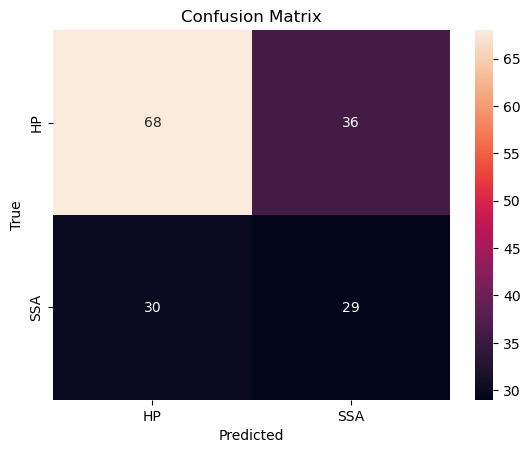

              precision    recall  f1-score   support

          HP       0.69      0.65      0.67       104
         SSA       0.45      0.49      0.47        59

    accuracy                           0.60       163
   macro avg       0.57      0.57      0.57       163
weighted avg       0.60      0.60      0.60       163



In [91]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

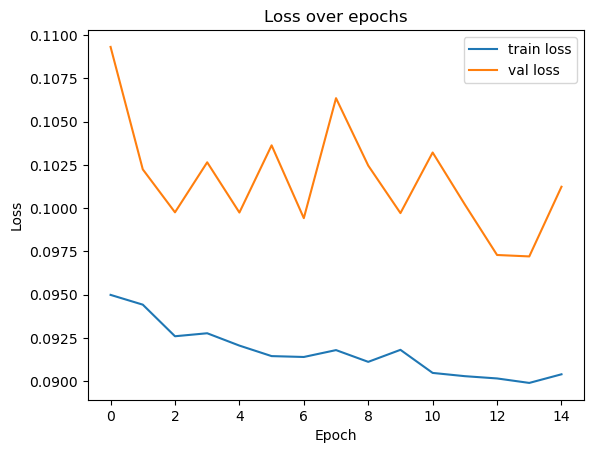

In [122]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_Loss_plot.png', dpi=300)
plt.show()

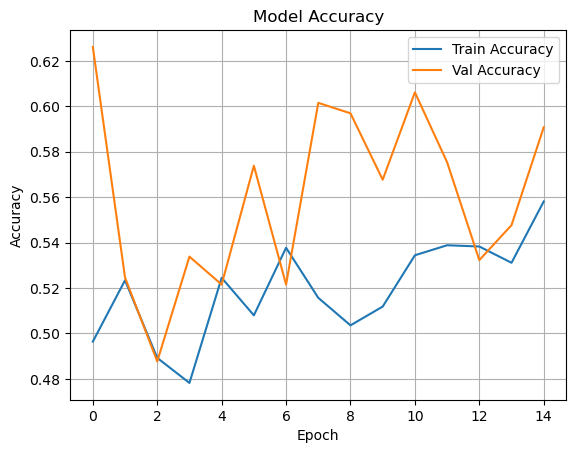

In [124]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_Accuracy_plot.png', dpi=300)
plt.show()

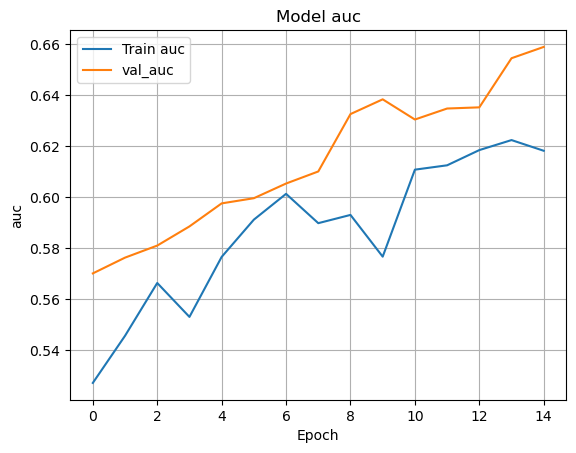

In [126]:
plt.plot(history.history['auc'], label='Train auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_AUC_plot.png', dpi=300)
plt.show()

## ResNet Fine-Tuning

In [101]:
# Разморозим верхнюю часть ResNet50 (fine-tuning)
trainable = False
for layer in resnet50_model.layers:
    if "conv5_block" in layer.name:
        trainable = True
    layer.trainable = trainable

In [103]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # уменьшить LR при fine-tuning!
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)

In [108]:
# Продолжим обучение ещё на несколько эпох
history_finetune = resnet50_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 78s 683ms/step - accuracy: 0.8095 - auc: 0.8503 - loss: 0.4221 - val_accuracy: 0.7092 - val_auc: 0.8398 - val_loss: 0.6203
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 76s 665ms/step - accuracy: 0.8285 - auc: 0.8812 - loss: 0.3725 - val_accuracy: 0.7323 - val_auc: 0.8440 - val_loss: 0.5444
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 76s 670ms/step - accuracy: 0.8382 - auc: 0.8879 - loss: 0.3695 - val_accuracy: 0.7692 - val_auc: 0.8513 - val_loss: 0.4845
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 77s 671ms/step - accuracy: 0.8371 - auc: 0.8907 - loss: 0.3560 - val_accuracy: 0.7523 - val_auc: 0.8448 - val_loss: 0.4970
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 77s 679ms/step - accuracy: 0.8186 - auc: 0.8695 - loss: 0.3940 - val_accuracy: 0.7615 - val_auc: 0.8652 - val_loss: 0.5500
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 76s 666ms/step - accuracy: 0.8605 - auc: 0.9135 - loss: 0.3171 - val_accuracy: 0.7631 - val_auc: 0.8555 - val_loss: 0.4713
Epoch 7/20
114/114 ━━━

In [110]:
resnet50_model.save("resnet50_finetuned_model.keras")

In [112]:
from tensorflow.keras.models import load_model
resnet50_model = load_model(
    "resnet50_finetuned_model.keras",
    custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.75)}
)

In [114]:
# Получаем вероятности (от 0 до 1)
pred_probs = resnet50_model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 653ms/step


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP

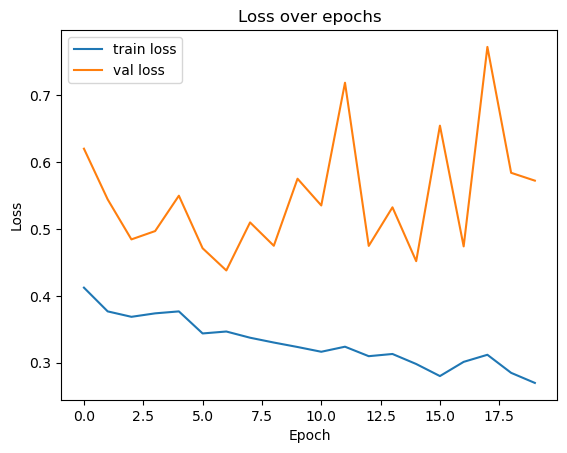

In [128]:
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_finetooned_Loss_plot.png', dpi=300)
plt.show()

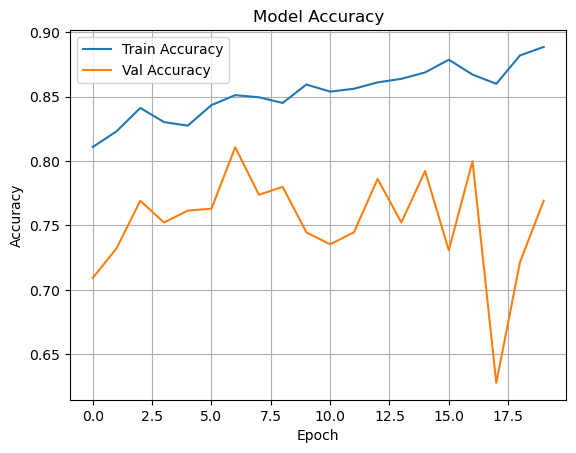

In [130]:
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_finetooned_Accuracy_plot.png', dpi=300)
plt.show()

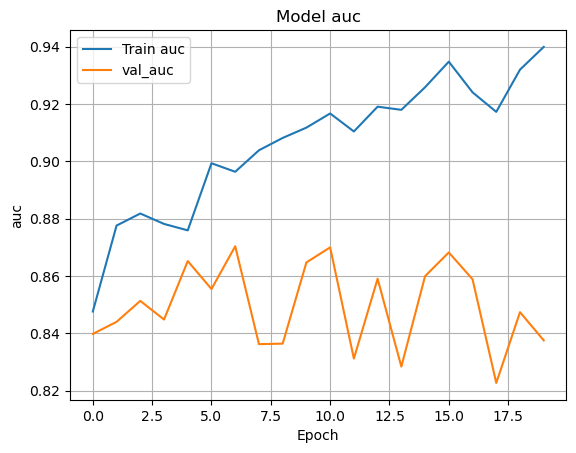

In [132]:
plt.plot(history_finetune.history['auc'], label='Train auc')
plt.plot(history_finetune.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_finetooned_AUC_plot.png', dpi=300)
plt.show()

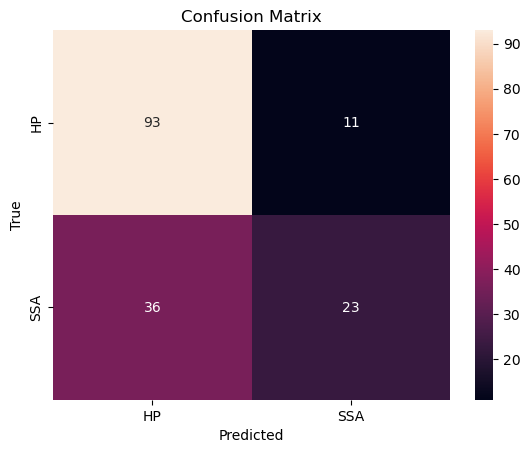

              precision    recall  f1-score   support

          HP       0.72      0.89      0.80       104
         SSA       0.68      0.39      0.49        59

    accuracy                           0.71       163
   macro avg       0.70      0.64      0.65       163
weighted avg       0.70      0.71      0.69       163



In [134]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/ResNet_finetooned_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

## RandomSearch ResNet50

In [83]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, clone_model, load_model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from keras_tuner import RandomSearch
import tensorflow as tf
import pandas as pd

# 📌 Функция focal loss
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return loss

In [144]:
# 📌 Модель с замороженной ResNet50 и параметрами головы
def build_resnet50_model(hp):
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=Input(shape=(224, 224, 3))
    )
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('dense_units', 64, 256, step=64))(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-4])),
        loss=focal_loss(
            gamma=hp.Choice('gamma', [1.0, 1.5, 2.0]),
            alpha=hp.Choice('alpha', [0.5, 0.75, 0.9])
        ),
        metrics=['accuracy', 'auc']
    )

    return model

In [146]:
# 🔍 RandomSearch по голове
tuner = RandomSearch(
    build_resnet50_model,
    objective='val_auc',
    max_trials=10,
    directory='resnet50_tuning',
    project_name='frozen'
)


# Остановка по валидации
early_stop = EarlyStopping(
    monitor='val_loss',        # Можно также 'val_accuracy'
    patience=3,                # Сколько эпох ждать без заметного улучшения
    min_delta=0.01,           # Минимальное улучшение между эпохами
    restore_best_weights=True,
    verbose=1
)


tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop])

Trial 10 Complete [00h 05m 51s]
val_auc: 0.7331736087799072

Best val_auc So Far: 0.8042505979537964
Total elapsed time: 00h 54m 55s


In [147]:
# 💾 Сохраняем лучшую модель
best_model_frozen = tuner.get_best_models(1)[0]
best_model_frozen.save("resnet50_frozen_tuned.h5")

C:\Users\user\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [152]:
# 📊 Сохраняем таблицу с результатами
frozen_trials = tuner.oracle.get_best_trials(num_trials=100)
frozen_records = []
for trial in frozen_trials:
    data = trial.hyperparameters.values.copy()
    data['val_auc'] = trial.metrics.get_last_value('val_auc')
    data['val_accuracy'] = trial.metrics.get_last_value('val_accuracy')
    data['val_loss'] = trial.metrics.get_last_value('val_loss')
    frozen_records.append(data)

frozen_df = pd.DataFrame(frozen_records)
frozen_df.to_excel("C:/Users/user/Desktop/Tensor-FLow Project/resnet50_frozen_results.xlsx", index=False)
display(frozen_df.head())



dense_units  dropout_rate      lr  gamma  alpha   val_auc  val_accuracy  \
0          128           0.2  0.0001    1.0   0.75  0.804251      0.738462   
1          128           0.4  0.0001    1.5   0.50  0.771212      0.636923   
2           64           0.3  0.0001    1.5   0.50  0.765194      0.412308   
3           64           0.4  0.0001    1.5   0.90  0.759063      0.663077   
4          256           0.4  0.0001    2.0   0.50  0.756387      0.644615   

   val_loss  
0  0.136593  
1  0.210655  
2  0.197578  
3  0.088734  
4  0.092968

In [156]:
corr_matrix = frozen_df.corr()
corr_matrix

dense_units  dropout_rate  lr     gamma     alpha   val_auc  \
dense_units      1.000000      0.022272 NaN  0.561801 -0.271896 -0.529636   
dropout_rate     0.022272      1.000000 NaN  0.289570  0.045104  0.103417   
lr                    NaN           NaN NaN       NaN       NaN       NaN   
gamma            0.561801      0.289570 NaN  1.000000 -0.656907 -0.436659   
alpha           -0.271896      0.045104 NaN -0.656907  1.000000  0.067085   
val_auc         -0.529636      0.103417 NaN -0.436659  0.067085  1.000000   
val_accuracy     0.003730      0.398419 NaN -0.410270  0.573389  0.547607   
val_loss        -0.000188     -0.440172 NaN  0.226147 -0.711430 -0.179191   

              val_accuracy  val_loss  
dense_units       0.003730 -0.000188  
dropout_rate      0.398419 -0.440172  
lr                     NaN       NaN  
gamma            -0.410270  0.226147  
alpha             0.573389 -0.711430  
val_auc           0.547607 -0.179191  
val_accuracy      1.000000 -0.657445  
val_loss         -0.657445  1.000000

In [158]:
frozen_df

dense_units  dropout_rate      lr  gamma  alpha   val_auc  val_accuracy  \
0          128           0.2  0.0001    1.0   0.75  0.804251      0.738462   
1          128           0.4  0.0001    1.5   0.50  0.771212      0.636923   
2           64           0.3  0.0001    1.5   0.50  0.765194      0.412308   
3           64           0.4  0.0001    1.5   0.90  0.759063      0.663077   
4          256           0.4  0.0001    2.0   0.50  0.756387      0.644615   
5          128           0.3  0.0001    2.0   0.50  0.752180      0.415385   
6           64           0.3  0.0001    1.0   0.90  0.749616      0.612308   
7          256           0.4  0.0001    2.0   0.75  0.739151      0.687692   
8          192           0.3  0.0001    1.0   0.90  0.733174      0.607692   
9          256           0.2  0.0001    2.0   0.50  0.695847      0.367692   

   val_loss  
0  0.136593  
1  0.210655  
2  0.197578  
3  0.088734  
4  0.092968  
5  0.146405  
6  0.085436  
7  0.072706  
8  0.090877  
9  0.248857

## RandomSearch ResNet50 Fine-Tuning 

In [161]:
# 📥 Загружаем модель для fine-tuning
base_model_full = load_model("resnet50_frozen_tuned.h5", custom_objects={
    'loss': focal_loss(gamma=1.0, alpha=0.75)
})

# 📌 Модель для дообучения с разморозкой N слоёв
def build_fine_tune_model(hp):
    model = clone_model(base_model_full)
    model.set_weights(base_model_full.get_weights())

    unfreeze_layers = hp.Int('unfreeze_layers', min_value=20, max_value=100, step=20)

    trainable_layers = [
        layer for layer in model.layers
        if any(substr in layer.name for substr in ['conv', 'bn', 'pool']) and hasattr(layer, 'trainable')
    ]

    for layer in trainable_layers[:-unfreeze_layers]:
        layer.trainable = False
    for layer in trainable_layers[-unfreeze_layers:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-4, 3e-5])),
        loss=focal_loss(gamma=1.0, alpha=0.75),
        metrics=['accuracy', AUC(name='auc')]
    )

    return model

In [165]:
# 🔍 RandomSearch по размораживанию
fine_tuner = RandomSearch(
    build_fine_tune_model,
    objective='val_auc',
    max_trials=6,
    directory='resnet50_finetune',
    project_name='resnet_unfreeze_search'
)

fine_tuner.search(train_gen, validation_data=val_gen, epochs=10, callbacks=[early_stop])

Trial 6 Complete [00h 07m 51s]
val_auc: 0.7962110042572021

Best val_auc So Far: 0.8610650897026062
Total elapsed time: 01h 08m 55s


In [167]:
# 📊 Сохраняем результаты fine-tuning в Excel
fine_trials = fine_tuner.oracle.get_best_trials(num_trials=100)
fine_records = []
for trial in fine_trials:
    data = trial.hyperparameters.values.copy()
    data['val_auc'] = trial.metrics.get_last_value('val_auc')
    data['val_accuracy'] = trial.metrics.get_last_value('val_accuracy')
    data['val_loss'] = trial.metrics.get_last_value('val_loss')
    fine_records.append(data)

fine_df = pd.DataFrame(fine_records)
fine_df.to_excel("resnet50_finetune_results.xlsx", index=False)
display(fine_df.head())

# 💾 Сохраняем лучшую fine-tuned модель
best_model_finetuned = fine_tuner.get_best_models(1)[0]
best_model_finetuned.save("resnet50_finetuned_best.h5")

unfreeze_layers       lr   val_auc  val_accuracy  val_loss
0              100  0.00010  0.861065      0.750769  0.097656
1              100  0.00003  0.858706      0.746154  0.098525
2               60  0.00010  0.807766      0.695385  0.116685
3               80  0.00003  0.804399      0.740000  0.159601
4               60  0.00003  0.796211      0.738462  0.164545

C:\Users\user\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 254 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [171]:
fine_df

unfreeze_layers       lr   val_auc  val_accuracy  val_loss
0              100  0.00010  0.861065      0.750769  0.097656
1              100  0.00003  0.858706      0.746154  0.098525
2               60  0.00010  0.807766      0.695385  0.116685
3               80  0.00003  0.804399      0.740000  0.159601
4               60  0.00003  0.796211      0.738462  0.164545
5               80  0.00010  0.771852      0.490769  0.155227

In [173]:
corr1_matrix = fine_df.corr()
corr1_matrix

unfreeze_layers            lr   val_auc  val_accuracy  \
unfreeze_layers     1.000000e+00  9.484793e-17  0.723991      0.139192   
lr                  9.484793e-17  1.000000e+00 -0.095122     -0.518356   
val_auc             7.239909e-01 -9.512182e-02  1.000000      0.680737   
val_accuracy        1.391924e-01 -5.183556e-01  0.680737      1.000000   
val_loss           -6.077970e-01 -3.098569e-01 -0.865234     -0.360845   

                 val_loss  
unfreeze_layers -0.607797  
lr              -0.309857  
val_auc         -0.865234  
val_accuracy    -0.360845  
val_loss         1.000000

## Best trial ResNet50

In [85]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# Размер входного изображения
input_shape = (224, 224, 3)

# Базовая модель ResNet50 без верхушки (include_top=False), с весами ImageNet
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=input_shape)
)

# Замораживаем базовые слои
for layer in base_model.layers:
    layer.trainable = False

# Добавляем классификационную голову
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)  # Бинарная классификация

# Финальная модель
resnet50_model = Model(inputs=base_model.input, outputs=output)


def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha_t * tf.pow(1. - pt, gamma) * tf.math.log(pt)
    return loss


# Компиляция
resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', 'auc']
)

resnet50_model.summary()

Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,625 (90.98 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [87]:
# Остановка по валидации
# early_stop = EarlyStopping(
#     monitor='val_loss',        # Можно также 'val_accuracy'
#     patience=5,                # Сколько эпох ждать без заметного улучшения
#     min_delta=0.01,           # Минимальное улучшение между эпохами
#     restore_best_weights=True,
#     verbose=1
# )

# Чекпойнт модели
checkpoint = ModelCheckpoint('Best_trial_resnet50_model.keras', monitor='val_loss', save_best_only=True)

# Обучение
history = resnet50_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20


C:\Users\user\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_661']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


114/114 ━━━━━━━━━━━━━━━━━━━━ 87s 652ms/step - accuracy: 0.4472 - auc: 0.5311 - loss: 0.1457 - val_accuracy: 0.3631 - val_auc: 0.7143 - val_loss: 0.1399
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 73s 641ms/step - accuracy: 0.5650 - auc: 0.6569 - loss: 0.1253 - val_accuracy: 0.6738 - val_auc: 0.7127 - val_loss: 0.1473
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 72s 628ms/step - accuracy: 0.6093 - auc: 0.6893 - loss: 0.1222 - val_accuracy: 0.6446 - val_auc: 0.7230 - val_loss: 0.1701
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 75s 659ms/step - accuracy: 0.6159 - auc: 0.7124 - loss: 0.1198 - val_accuracy: 0.3985 - val_auc: 0.7358 - val_loss: 0.1349
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 74s 644ms/step - accuracy: 0.6585 - auc: 0.7525 - loss: 0.1119 - val_accuracy: 0.6785 - val_auc: 0.7494 - val_loss: 0.1310
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 73s 636ms/step - accuracy: 0.6447 - auc: 0.7373 - loss: 0.1129 - val_accuracy: 0.6585 - val_auc: 0.7117 - val_loss: 0.1670
Epoch 7/20
114/114 ━━━━━━━━━━━━━━

In [89]:
resnet50_model.save('best_trial_resnet50_model.keras')

In [156]:
from tensorflow.keras.models import load_model
resnet50_model = load_model(
    'best_trial_resnet50_model.keras',
    custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)}
)

In [158]:
# Получаем вероятности (от 0 до 1)
pred_probs = resnet50_model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 671ms/step


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA

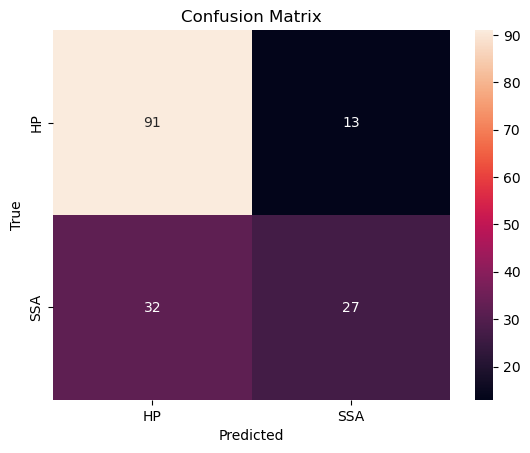

              precision    recall  f1-score   support

          HP       0.74      0.88      0.80       104
         SSA       0.68      0.46      0.55        59

    accuracy                           0.72       163
   macro avg       0.71      0.67      0.67       163
weighted avg       0.72      0.72      0.71       163



In [205]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_confision_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

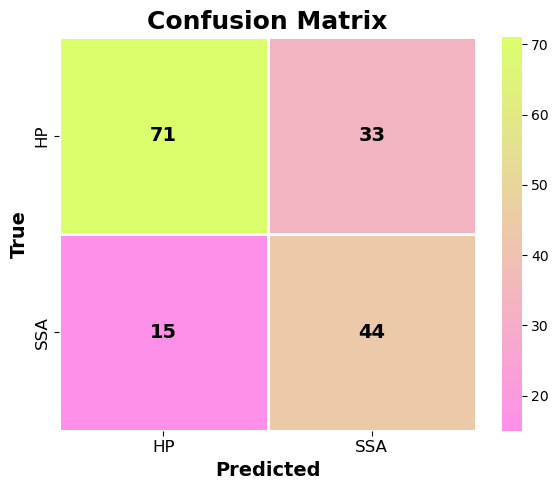

In [159]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Создание кастомного градиентного colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#ff90ea", "#dbff6c"])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=custom_cmap,  # градиент
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            linewidths=1,
            linecolor='white',
            annot_kws={"size": 14, "weight": "bold", "color": "black"})

# Оформление
plt.title("Confusion Matrix", fontsize=18, weight='bold')
plt.xlabel("Predicted", fontsize=14, weight='bold')
plt.ylabel("True", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/Новые_до_finetuning/Forpres_Resnet_matrix_plot.png', dpi=300, transparent=True)
plt.show()

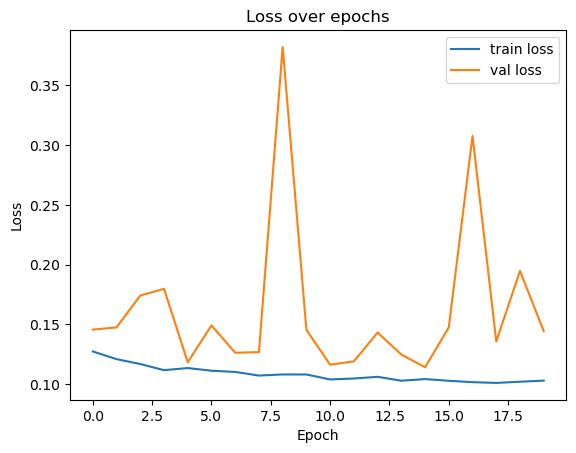

In [206]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_Loss_plot.png', dpi=300)
plt.show()

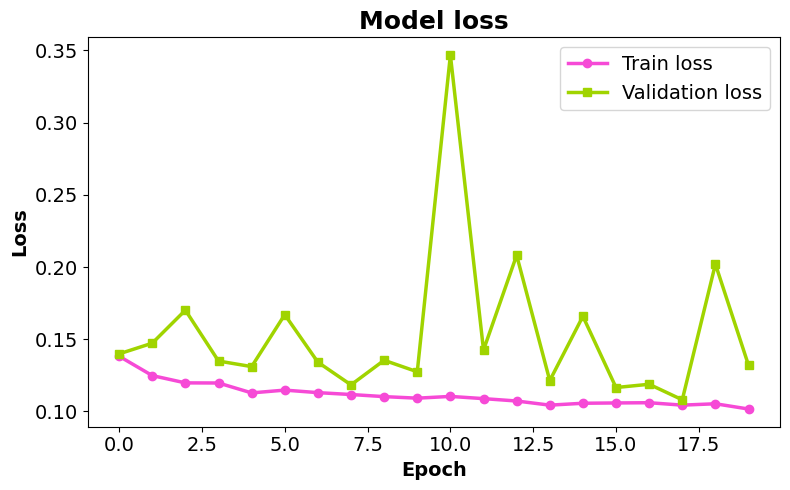

In [116]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history.history['loss'], label='Train loss',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history.history['val_loss'], label='Validation loss',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model loss", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Loss", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/Forpres_ResNet_loss_plot.png', dpi=300, transparent=True)
plt.show()

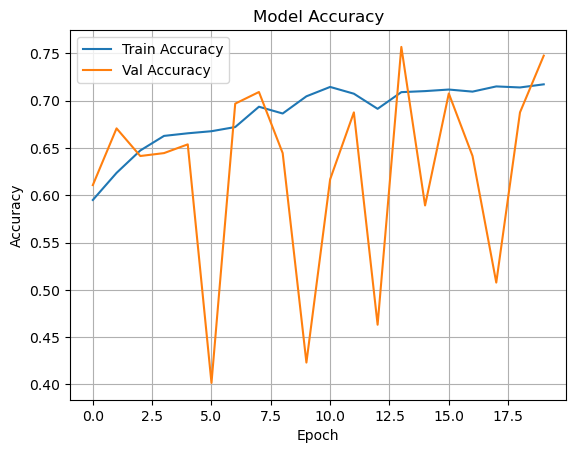

In [207]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_Accuracy_plot.png', dpi=300)
plt.show()

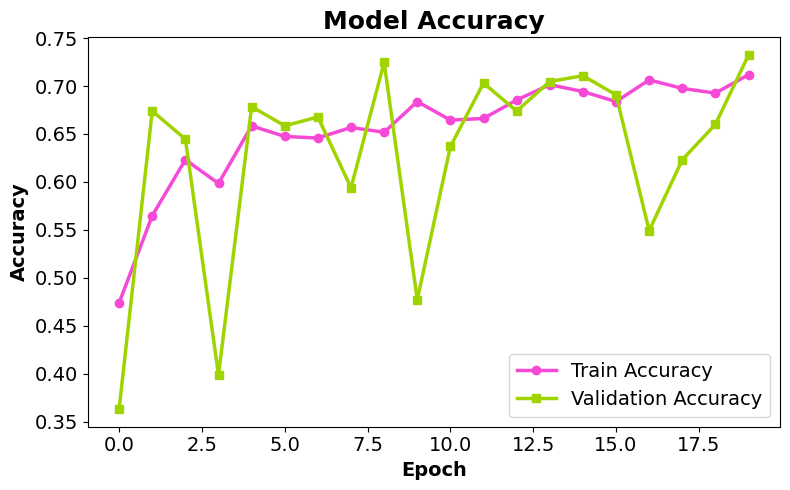

In [118]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history.history['accuracy'], label='Train Accuracy',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model Accuracy", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Accuracy", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/Forpres_ResNet_Accuracy_plot.png', dpi=300, transparent=True)
plt.show()

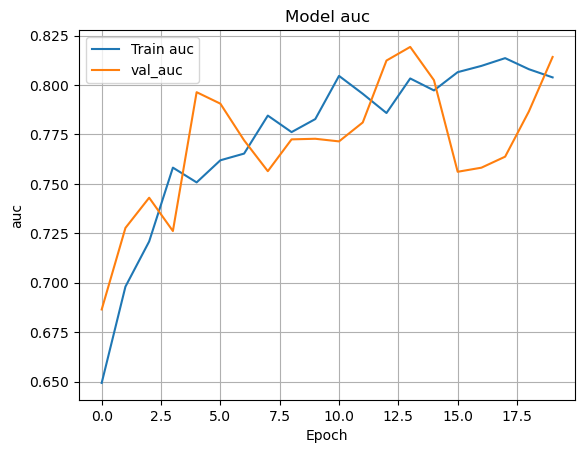

In [208]:
plt.plot(history.history['auc'], label='Train auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_AUC_plot.png', dpi=300)
plt.show()

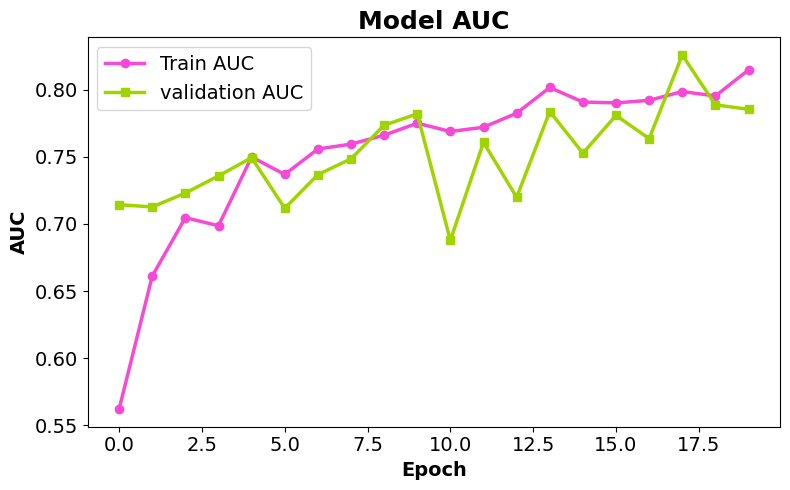

In [162]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history.history['auc'], label='Train AUC',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history.history['val_auc'], label='validation AUC',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model AUC", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("AUC", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/Forpres_ResNet_AUC_plot.png', dpi=300, transparent=True)
plt.show()

## Best trial ResNet50 fine-tuning

In [122]:
for layer in resnet50_model.layers[:-100]:
    layer.trainable = False
for layer in resnet50_model.layers[-100:]:
    layer.trainable = True

In [124]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

resnet50_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # уменьшить LR при fine-tuning!
    loss=focal_loss(gamma=1.0, alpha=0.75),
    metrics=['accuracy', 'auc']
)

# Продолжим обучение ещё на несколько эпох
history_finetune = resnet50_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.6636 - auc: 0.5751 - loss: 0.2648 - val_accuracy: 0.3815 - val_auc: 0.6276 - val_loss: 0.2678
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 113s 990ms/step - accuracy: 0.7127 - auc: 0.7536 - loss: 0.1362 - val_accuracy: 0.5846 - val_auc: 0.6131 - val_loss: 0.1879
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 114s 997ms/step - accuracy: 0.6726 - auc: 0.7466 - loss: 0.1337 - val_accuracy: 0.5308 - val_auc: 0.6523 - val_loss: 0.1638
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 112s 980ms/step - accuracy: 0.7015 - auc: 0.7941 - loss: 0.1149 - val_accuracy: 0.5769 - val_auc: 0.7374 - val_loss: 0.1537
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 112s 983ms/step - accuracy: 0.6917 - auc: 0.7855 - loss: 0.1187 - val_accuracy: 0.7046 - val_auc: 0.7669 - val_loss: 0.1454
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 112s 985ms/step - accuracy: 0.7079 - auc: 0.8145 - loss: 0.1113 - val_accuracy: 0.6908 - val_auc: 0.7914 - val_loss: 0.1253
Epoch 7/20
114/114 

In [126]:
resnet50_model.save("best_trial_unfrozen_resnet50_finetuned_model.keras")

In [128]:
from tensorflow.keras.models import load_model
resnet50_model = load_model(
    "best_trial_unfrozen_resnet50_finetuned_model.keras",
    custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)}
)

In [130]:
# Получаем вероятности (от 0 до 1)
pred_probs = resnet50_model.predict(test_gen)

# Преобразуем вероятности в метки (0 или 1)
pred_labels = (pred_probs > 0.5).astype(int).flatten()

true_labels = test_gen.classes  # Истинные метки
class_names = list(test_gen.class_indices.keys())

import pandas as pd

results = pd.DataFrame({
    'Filename': test_gen.filenames,
    'True': [class_names[i] for i in true_labels],
    'Predicted': [class_names[i] for i in pred_labels]
})

results.head(40)

11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 864ms/step


Filename True Predicted
0   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
1   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
2   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
3   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
4   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
5   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
6   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
7   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
8   C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
9   C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
10  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
11  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
12  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
13  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
14  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
15  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
16  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
17  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
18  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA        HP
19  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
20  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
21  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
22  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
23  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
24  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
25  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
26  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
27  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
28  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
29  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
30  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
31  C:/Users/user/Desktop/Tensor-FLow Project/imag...  SSA       SSA
32  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
33  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA
34  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
35  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
36  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
37  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
38  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP        HP
39  C:/Users/user/Desktop/Tensor-FLow Project/imag...   HP       SSA

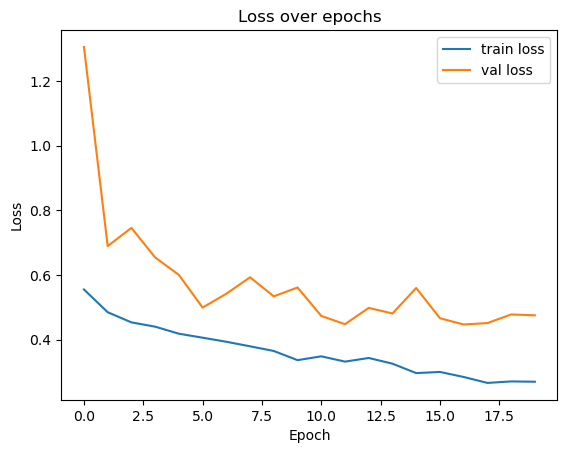

In [220]:
plt.plot(history_finetune.history['loss'], label='train loss')
plt.plot(history_finetune.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_finetooned_Loss_plot.png', dpi=300)
plt.show()

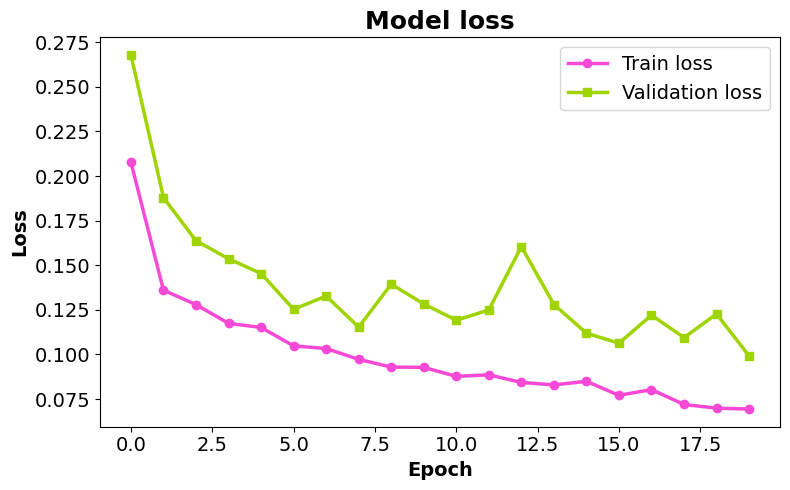

In [134]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_finetune.history['loss'], label='Train loss',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_finetune.history['val_loss'], label='Validation loss',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model loss", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Loss", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/afterfineForpres_ResNet_loss_plot.png', dpi=300, transparent=True)
plt.show()

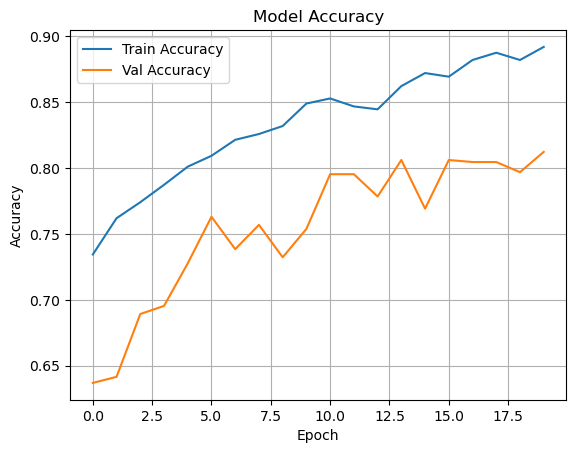

In [221]:
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_finetooned_Accuracy_plot.png', dpi=300)
plt.show()

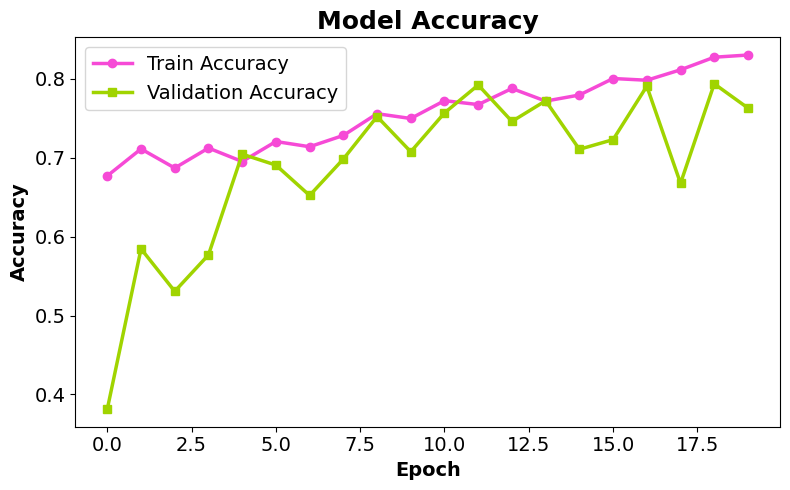

In [136]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model Accuracy", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("Accuracy", fontsize=14, weight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/afterfineForpres_ResNet_Accuracy_plot.png', dpi=300, transparent=True)
plt.show()

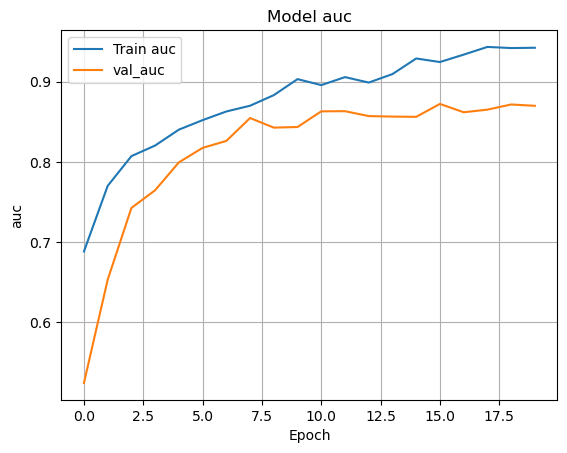

In [222]:
plt.plot(history_finetune.history['auc'], label='Train auc')
plt.plot(history_finetune.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('auc')
plt.title('Model auc')
plt.legend()
plt.grid(True)
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_finetooned_AUC_plot.png', dpi=300)
plt.show()

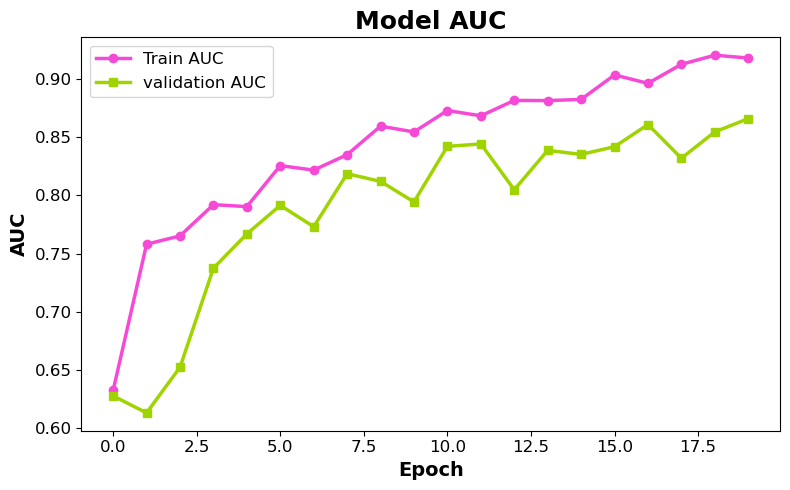

In [164]:
plt.figure(figsize=(8, 5))

# Графики с фирменными цветами
plt.plot(history_finetune.history['auc'], label='Train AUC',
         color='#f64ad6', linewidth=2.5, marker='o')
plt.plot(history_finetune.history['val_auc'], label='validation AUC',
         color='#A0D400', linewidth=2.5, marker='s')

# Оформление
plt.title("Model AUC", fontsize=18, weight='bold')
plt.xlabel("Epoch", fontsize=14, weight='bold')
plt.ylabel("AUC", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/afterfineForpres_ResNet_AUC_plot.png', dpi=300, transparent=True)
plt.show()

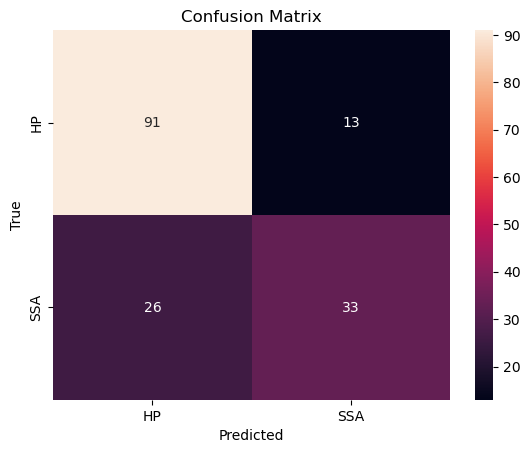

              precision    recall  f1-score   support

          HP       0.78      0.88      0.82       104
         SSA       0.72      0.56      0.63        59

    accuracy                           0.76       163
   macro avg       0.75      0.72      0.73       163
weighted avg       0.76      0.76      0.75       163



In [223]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('C:/Users/user/Desktop/Tensor-FLow Project/Plots/ResNet/best_trial_resnet50_finetooned_matrix_plot.png', dpi=300)
plt.show()

print(classification_report(true_labels, pred_labels, target_names=class_names))

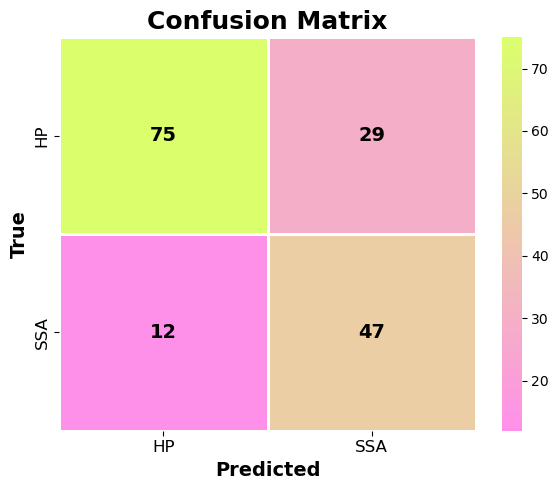

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Создание кастомного градиентного colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", ["#ff90ea", "#dbff6c"])

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap=custom_cmap,  # градиент
            xticklabels=class_names,
            yticklabels=class_names,
            cbar=True,
            linewidths=1,
            linecolor='white',
            annot_kws={"size": 14, "weight": "bold", "color": "black"})

# Оформление
plt.title("Confusion Matrix", fontsize=18, weight='bold')
plt.xlabel("Predicted", fontsize=14, weight='bold')
plt.ylabel("True", fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("C:\Users\user\Desktop\Tensor-FLow Project\Plots\ResNet\Новые_после_finetuning\afterfineForpres_Resnet_matrix_plot.png", dpi=300, transparent=True)
plt.show()

In [172]:
from tensorflow.keras.models import load_model

BestCNNmodel = load_model('AfterSearchCNNbest_model.keras', custom_objects={'loss': focal_loss(gamma=1.5, alpha=0.5)})

In [173]:
resnet50_model = load_model(
    "best_trial_unfrozen_resnet50_finetuned_model.keras",
    custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)}
)

In [174]:
model = load_model('FINAL_finetuned_densenet_model.keras',
                   custom_objects={'loss': focal_loss(gamma=1.0, alpha=0.75)})

In [197]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_from_generator(model, generator):
    y_true = generator.classes
    y_pred_probs = model.predict(generator).flatten()
    y_pred = (y_pred_probs > 0.5).astype("int32")
    
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)  # AUC рассчитывается по вероятностям

    return acc, prec, rec, f1, auc

In [217]:
results = []

models = {
    "CNN Best": BestCNNmodel,
    "ResNet50 Finetuned": resnet50_model,
    "DenseNet Finetuned": model
}

for name, mdl in models.items():
    auc, acc, prec, rec, f1 = evaluate_model_from_generator(mdl, test_gen)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC": auc
    })

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 402ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 464ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 465ms/step


In [219]:
results_df = pd.DataFrame(results)
results_df.to_excel("C:/Users/user/Desktop/Tensor-FLow Project/RandomSearchs/valFinal_models_results.xlsx", index=False)

In [205]:
results_df

Model  Accuracy  Precision    Recall  F1-score       AUC
0            CNN Best  0.485714   0.288136  0.361702  0.709094  0.631902
1  ResNet50 Finetuned  0.597403   0.779661  0.676471  0.820241  0.730061
2  DenseNet Finetuned  0.680556   0.830508  0.748092  0.886245  0.797546

In [215]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import openpyxl
from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
from openpyxl.utils.dataframe import dataframe_to_rows

def evaluate_model_from_generator(model, generator):
    y_true = generator.classes
    y_pred_probs = model.predict(generator).flatten()
    y_pred = (y_pred_probs > 0.5).astype("int32")

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_probs)

    return acc, prec, rec, f1, auc

# Оценка всех моделей
results = []

models = {
    "CNN Best": BestCNNmodel,
    "ResNet50 Finetuned": resnet50_model,
    "DenseNet Finetuned": model
}

for name, mdl in models.items():
    acc, prec, rec, f1, auc = evaluate_model_from_generator(mdl, test_gen)
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC": auc
    })

# Создание DataFrame
df = pd.DataFrame(results)

# Округление для презентации
df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: round(x, 3))

# Выделим жирным лучший результат по каждой метрике
best_values = df.iloc[:, 1:].max()

# Создание Excel-файла с форматированием
wb = openpyxl.Workbook()
ws = wb.active
ws.title = "Model Evaluation"

# Заголовки
header_font = Font(bold=True, color="FFFFFF")
header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
border = Border(
    left=Side(style="thin"), right=Side(style="thin"),
    top=Side(style="thin"), bottom=Side(style="thin")
)

for r_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), 1):
    for c_idx, value in enumerate(row, 1):
        cell = ws.cell(row=r_idx, column=c_idx, value=value)
        cell.alignment = Alignment(horizontal="center", vertical="center")
        cell.border = border

        if r_idx == 1:
            cell.font = header_font
            cell.fill = header_fill
        elif c_idx > 1:
            metric_name = df.columns[c_idx - 1]
            if value == round(best_values[metric_name], 3):
                cell.font = Font(bold=True)

# Настройка ширины колонок
for col in ws.columns:
    max_length = max(len(str(cell.value)) for cell in col)
    ws.column_dimensions[col[0].column_letter].width = max_length + 2

# Сохранение
wb.save("C:/Users/user/Desktop/Tensor-FLow Project/RandomSearchs/presentation_ready_model_comparison.xlsx")

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_2456\1247071876.py:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df.iloc[:, 1:] = df.iloc[:, 1:].applymap(lambda x: round(x, 3))
